<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/main/Time_Series_Labelling_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import Libraries

In [ ]:
# Import Libraries 
import itertools as itt
import numbers
import numpy as np
import pandas as pd
from abc import abstractmethod
from typing import Iterable, Tuple, List
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import xgboost as xgb
from prettytable import PrettyTable
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor

# Functions

In [ ]:
# Labelling algorithm X is price and th is our threshould

def labeling(X, th):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP = X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*th):
            xh, HT, FP_N, cid  = X[i], i, i, 1
            break
        if(X[i] < FP - X[0]*th):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh, HT = X[i], i
            if(X[i] < xh - xh * th and LT<= HT):
                for j in range(n):
                    if(j > LT and j <= HT):
                        y[j] = 1
                xl, LT, cid = X[i], i, -1
        if(cid < 0):
            if(X[i] < xl):
                xl, LT = X[i], i
            if(X[i] > xl + xl * th and HT <= LT):
                for j in range(n):
                    if(j > HT and j <= LT):
                        y[j] = 0
                xh, HT, cid = X[i], i, 1
    return y


In [ ]:
# Implement Cross-validation methods

class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])
        
class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=0):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if embargo_td < 0:
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[cv.indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])

    return np.concatenate((train_indices_1, train_indices_2))

In [ ]:
def get_metrics(label, y_pred, show_results=False):
  
  results = []
  results.append(metrics.accuracy_score(label, y_pred))
  results.append(metrics.precision_score(label, y_pred))
  results.append(metrics.recall_score(label, y_pred))
  results.append(metrics.f1_score(label, y_pred))

  if show_results:
    print("Accuracy:{:.6f}".format(metrics.accuracy_score(label, y_pred)))
    print("Precision:{:.6f}".format(metrics.precision_score(label, y_pred)))
    print("Recall:{:.6f}".format(metrics.recall_score(label, y_pred)))
    print("F1 score:{:.6f}".format(metrics.f1_score(label, y_pred)))
    
  return results

In [ ]:
def data_pre1d(df, index, label, step_size):
  x = np.array([df[i + step_size - 1:i+step_size*11:step_size] for i in index if (i-1 + 11*step_size) in index])
  y = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  x = x / np.mean(x,axis = 1).reshape((len(x), 1))
  x = x - np.ones((len(x), 1))
  x = x.reshape(x.shape[0], x.shape[1], 1)
  y = (y + 1) // 2
  return x, y

In [ ]:
def denoise_data(df, col_name, k=100):
  clf = KNeighborsRegressor(n_neighbors=k, weights='uniform')
  clf.fit(df.index.values[:, np.newaxis], df["<CLOSE>"])
  y_pred = clf.predict(df.index.values[:, np.newaxis])  
  reverse_pred = y_pred[::-1]
  ax = pd.Series(df["<CLOSE>"]).plot(color='lightgray')
  pd.Series(y_pred).plot(color='black', ax=ax, figsize=(12, 8))
  plt.title("Denoising data")
  df['<CLOSE>'] = y_pred
  return df

In [ ]:
def visualize(dfs, col_name, date, th, start, end):
  label = labeling(dfs[col_name], th)
  # date_col = dfs[date].astype(str).str[:4]
  date_col = dfs[date]
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=date_col[start:end], y=dfs[col_name][start:end]))
  fig.show()
  fig = go.Figure([go.Scatter(x=date_col[start:end], y=label[start:end])])
  fig.show() 

In [ ]:
# Define a class for training models

class Train_data():
  def __init__(self, data,  train_start, train_end, test_end):
    self.train_start = train_start
    self.train_end = train_end
    self.test_end = test_end 
    self.data = data
    self.train_data = pd.Series(np.array(data[train_start:train_end]))
    self.train_label = None
    self.test_data = pd.Series(np.array(data[train_end:test_end]))
    self.test_label = None
    self.splits = []
    self.X_train  = []
    self.y_train = []
    self.X_test  = []
    self.y_test = []
    self.GRU_beta_result = None
    self.LSTM_beta_result = None
    self.XGboost_beta_result = None
    self.SVM_beta_result = None
    self.Logreg_beta_result = None
    self.GRU_result = None
    self.LSTM_result = None
    self.XGboost_result = None
    self.SVM_result = None
    self.Logreg_result = None
    self.GRU_beta_predict = None
    self.LSTM_beta_predict = None
    self.XGboost_beta_predict = None
    self.SVM_beta_predict = None
    self.Logreg_beta_predict = None
    self.GRU_predict = None
    self.LSTM_predict = None
    self.XGboost_predict = None
    self.SVM_predict = None
    self.Logreg_predict = None

  def set_threshold(self, th):
    label  = labeling(self.data, th)
    self.train_label = pd.Series(np.array(label[self.train_start:self.train_end]))
    self.test_label = pd.Series(np.array(label[self.train_end:self.test_end]))

  def K_fold_purged(self, num_split, num_test, time_gaps, emb=0, purging=True):
    n_splits = num_split
    n_test_splits = num_test
    time_gap = time_gaps
    embargo_td = emb
    t1_ = self.train_data.index
    t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
    t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)
    
    if purging:
      cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)
      comb_purged_splits = list(cpkf.split(self.train_data, pred_times=t1, eval_times=t2))
      self.splits = comb_purged_splits
    
    else:
      cvts = TimeSeriesSplit(n_splits=n_splits)
      cvts_splits = list(cvts.split(self.train_data))
      self.splits = cvts_splits


  def SVM(self, beta):

    Xtrain = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1])
    clf = SVC(C=1)
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta : 
      self.SVM_beta_result  =  get_metrics(self.y_test, y_pred,0)
      self.SVM_beta_predict = y_pred    
    else:
      self.SVM_result  =  get_metrics(self.y_test,y_pred,0)
      self.SVM_predict = y_pred
    

  def log_reg(self, beta):
    
    Xtrain = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1])
    clf = LogisticRegression(C=10, penalty="l2")
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta: 
      self.Logreg_beta_result  =  get_metrics(self.y_test,y_pred,0)
      self.Logreg_beta_predict = y_pred
    else:
      self.Logreg_result  =  get_metrics(self.y_test,y_pred,0)
      self.Logreg_predict = y_pred
    
    

  def data_preprocess(self, step_size):  
    self.X_train, self.y_train = data_pre1d(self.train_data, self.train_data.index, self.train_label,step_size)
    self.X_test, self.y_test = data_pre1d(self.test_data, self.test_data.index, self.test_label,step_size)
    

  def LSTM(self, epoch, layer_size, window_size, lr, beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
      
      if beta:
        print(f'start lstm beta training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test, self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.LSTM_beta_result = get_metrics(self.y_test, y_pred, False)
        self.LSTM_beta_predict = y_pred
      else:
        print(f'start lstm training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test, self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.LSTM_result = get_metrics(self.y_test, y_pred, False)
        self.LSTM_predict = y_pred
      
      print('end training. \n')

  def GRU(self, epoch, layer_size, window_size, lr, beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if beta:
        print('start gru beta training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.GRU_beta_result = get_metrics(self.y_test,y_pred,False)
        self.GRU_beta_predict = y_pred
      else:
        print('start gru training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.GRU_result = get_metrics(self.y_test,y_pred,False)
        self.GRU_predict = y_pred

      print('end training. \n')

  def XGboost(self,es,beta):
    Xtrain = self.X_train.reshape(self.X_train.shape[0],self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0],self.X_test.shape[1])
    # XGBoost classifier with Early-stopping
    clf = xgb.XGBClassifier(n_jobs=1)
    if beta:
      print('start xgboost beta training...\n')
      clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
      y_pred = clf.predict(Xtest)
      self.XGboost_beta_result = get_metrics(self.y_test,y_pred,False)
      self.XGboost_beta_predict = y_pred
    else:
      print('start xgboost training...\n')
      clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
      y_pred = clf.predict(Xtest)
      self.XGboost_result = get_metrics(self.y_test,y_pred,False)
      self.XGboost_predict = y_pred

    print('end training. \n')


  def table(self, th = 0.1):
    x = PrettyTable()
    x.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 score"]
    self.LSTM_result.insert(0,"LSTM "+str(th))
    self.GRU_result.insert(0,"GRU "+str(th))
    self.XGboost_result.insert(0,"XGBoost "+str(th))
    self.Logreg_result.insert(0,"Logreg "+str(th))
    self.SVM_result.insert(0,"SVM "+str(th))
    self.LSTM_beta_result.insert(0,"LSTM beta "+str(th))
    self.GRU_beta_result.insert(0,"GRU beta "+str(th))
    self.XGboost_beta_result.insert(0,"XGBoost beta "+str(th))
    self.Logreg_beta_result.insert(0,"logreg beta "+str(th))
    self.SVM_beta_result.insert(0,"svm beta "+str(th))
    x.add_row(self.LSTM_result)
    x.add_row(self.GRU_result)
    x.add_row(self.XGboost_result)
    x.add_row(self.Logreg_result)
    x.add_row(self.SVM_result)
    x.add_row(self.LSTM_beta_result)
    x.add_row(self.GRU_beta_result)
    x.add_row(self.XGboost_beta_result)
    x.add_row(self.Logreg_beta_result)
    x.add_row(self.SVM_beta_result)
    return x


  
  def train_models(self, best_parameters, step_sizes=4, th = 0.1):

    lstm_epoch = best_parameters[0]
    lstm_layer = best_parameters[1]
    lstm_lr = best_parameters[2]
    gru_epoch = best_parameters[3]
    gru_layer = best_parameters[4]
    gru_lr = best_parameters[5]

    self.data_preprocess(step_size=1)
    self.LSTM(lstm_epoch, lstm_layer, 11, lstm_lr, False)
    self.GRU(gru_epoch, gru_layer, 11, gru_lr, False)
    self.XGboost(50, False)
    self.SVM(False)
    self.log_reg(False)

    self.data_preprocess(step_size=step_sizes)
    self.LSTM(lstm_epoch,lstm_layer,11,lstm_lr,True)
    self.GRU(gru_epoch,gru_layer,11,gru_lr,True)
    self.XGboost(50,True)
    self.SVM(True)
    self.log_reg(True)

    print(self.table(th = th))


In [ ]:
# Default best parameters

default_best_param = [5, 10, 0.01, 5, 10, 0.01]

def final_result(historical, name, best_param=default_best_param, step_sizes=4, th=0.1):
  historical.train_models(best_param, step_sizes, th=th)
  results = []
  results.append(historical.LSTM_result)
  results.append(historical.GRU_result)
  results.append(historical.XGboost_result)
  results.append(historical.Logreg_result)
  results.append(historical.SVM_result)
  results.append(historical.LSTM_beta_result)
  results.append(historical.GRU_beta_result)
  results.append(historical.XGboost_beta_result)
  results.append(historical.Logreg_beta_result)
  results.append(historical.SVM_beta_result)
  res = pd.DataFrame()
  
  for x in results:
    dic = {
      "Name": name,
      "Model": x[0],
      "acc": x[1],
      "Perc": x[2], 
      "recal": x[3], 
      "f1" :x[4]

    }
    res = res.append(dic, ignore_index=True)
  return res

# Results

## AMD

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.AMD,D,20101004,0,7.03,7.08,6.840,7.868584,22229263
1,US1.AMD,D,20101005,0,7.04,7.12,6.890,7.868584,34185258
2,US1.AMD,D,20101006,0,7.01,7.05,6.780,7.868584,23076122
3,US1.AMD,D,20101007,0,6.89,6.93,6.770,7.868584,20010148
4,US1.AMD,D,20101008,0,6.87,7.10,6.790,7.868584,24895450
...,...,...,...,...,...,...,...,...,...
2764,US1.AMD,D,20210927,0,104.99,108.43,103.440,94.725300,1337149
2765,US1.AMD,D,20210928,0,106.90,107.63,101.425,94.725300,1661005
2766,US1.AMD,D,20210929,0,102.16,102.64,99.820,94.725300,1241696
2767,US1.AMD,D,20210930,0,102.08,104.43,102.070,94.725300,1313306


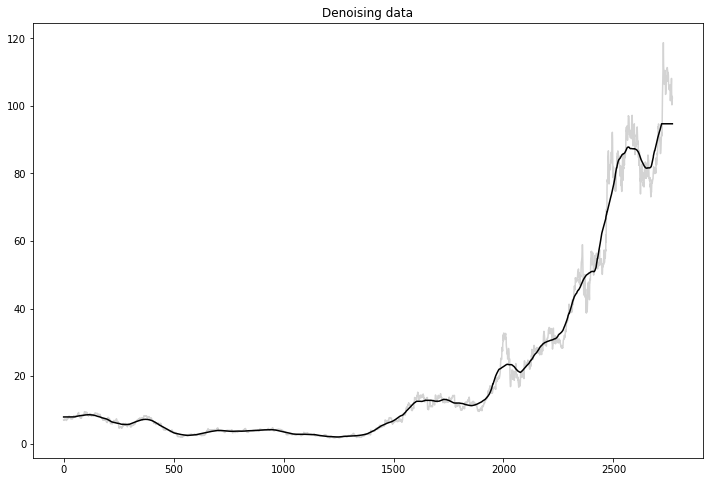

In [ ]:
dfs = pd.read_csv("AMD.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.1, .05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMD", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6871 - accuracy: 0.5574 - val_loss: 0.7528 - val_accuracy: 0.3347
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4816 - accuracy: 0.7769 - val_loss: 1.2270 - val_accuracy: 0.4122
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3635 - accuracy: 0.8367 - val_loss: 1.2250 - val_accuracy: 0.5367
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3258 - accuracy: 0.8503 - val_loss: 1.7383 - val_accuracy: 0.5102
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3027 - accuracy: 0.8669 - val_loss: 1.4181 - val_accuracy: 0.5551
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.5632 - accuracy: 0.6781 - val_loss: 1.4436 - val_accuracy: 0.5143
Epoch 2/5
106/106 [==============================] - 1s 10ms/step -

In [ ]:
Result_cross.to_csv('AMD_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,AMD,0.425824,0.555102,0.587121,0.945122
1,GRU 0.1,AMD,0.405063,0.512245,0.572451,0.975610
2,XGBoost 0.1,AMD,0.396088,0.491837,0.565445,0.987805
3,Logreg 0.1,AMD,0.397531,0.495918,0.565905,0.981707
4,SVM 0.1,AMD,0.402985,0.506122,0.572438,0.987805
5,LSTM beta 0.1,AMD,0.396040,0.457330,0.563380,0.975610
6,GRU beta 0.1,AMD,0.394937,0.459519,0.558140,0.951220
7,XGBoost beta 0.1,AMD,0.389163,0.444201,0.554386,0.963415
8,logreg beta 0.1,AMD,0.391414,0.452954,0.553571,0.945122
9,svm beta 0.1,AMD,0.395000,0.457330,0.560284,0.963415


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMD", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6866 - accuracy: 0.5568 - val_loss: 0.7148 - val_accuracy: 0.3347
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4074 - accuracy: 0.8254 - val_loss: 1.6396 - val_accuracy: 0.4980
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3047 - accuracy: 0.8716 - val_loss: 1.4614 - val_accuracy: 0.4980
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2763 - accuracy: 0.8763 - val_loss: 2.2512 - val_accuracy: 0.4857
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2629 - accuracy: 0.8787 - val_loss: 2.4357 - val_accuracy: 0.5122
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6232 - accuracy: 0.6320 - val_loss: 1.4866 - val_accuracy: 0.5143
Epoch 2/5
106/106 [==============================] - 1s 10ms/step -

In [ ]:
Result_purging.to_csv('AMD_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.05,AMD,0.646388,0.795918,0.772727,0.960452
1,GRU 0.05,AMD,0.939024,0.932653,0.903226,0.870056
2,XGBoost 0.05,AMD,0.825243,0.912245,0.887728,0.960452
3,Logreg 0.05,AMD,0.960526,0.924490,0.887538,0.824859
4,SVM 0.05,AMD,0.793296,0.853061,0.797753,0.802260
5,LSTM beta 0.05,AMD,0.710227,0.816193,0.748503,0.791139
6,GRU beta 0.05,AMD,0.770950,0.866521,0.818991,0.873418
7,XGBoost beta 0.05,AMD,0.839506,0.894967,0.850000,0.860759
8,logreg beta 0.05,AMD,0.834437,0.875274,0.815534,0.797468
9,svm beta 0.05,AMD,0.862069,0.884026,0.825083,0.791139


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg_beta_p.csv')

## AAPL

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.AAPL,D,20101004,0,281.60,282.90,277.7700,323.93085,14964464
1,US1.AAPL,D,20101005,0,281.96,289.44,281.8205,323.93085,16379352
2,US1.AAPL,D,20101006,0,289.64,291.99,285.2600,323.93085,22791119
3,US1.AAPL,D,20101007,0,290.26,290.48,286.9100,323.93085,13965617
4,US1.AAPL,D,20101008,0,291.83,294.50,290.0000,323.93085,21492761
...,...,...,...,...,...,...,...,...,...
2762,US1.AAPL,D,20210927,0,145.40,145.96,143.8300,140.59160,3504880
2763,US1.AAPL,D,20210928,0,143.19,144.75,141.7000,140.59160,5602142
2764,US1.AAPL,D,20210929,0,142.47,144.45,142.0300,140.59160,3205269
2765,US1.AAPL,D,20210930,0,143.67,144.37,141.2900,140.59160,4102531


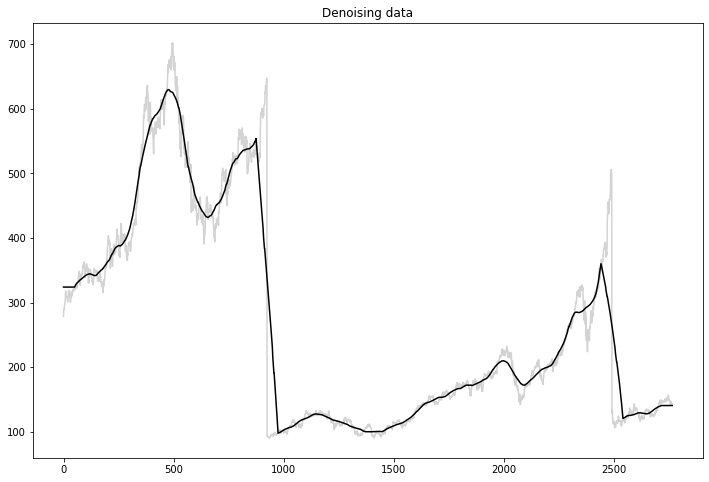

In [ ]:
dfs = pd.read_csv("AAPL.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "AAPL", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6278 - accuracy: 0.6882 - val_loss: 0.5262 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6229 - accuracy: 0.6899 - val_loss: 0.5486 - val_accuracy: 0.8082
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5623 - accuracy: 0.7580 - val_loss: 0.5116 - val_accuracy: 0.8082
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5815 - accuracy: 0.7379 - val_loss: 0.5112 - val_accuracy: 0.8082
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3578 - accuracy: 0.8669 - val_loss: 0.1145 - val_accuracy: 0.9490
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6260 - accuracy: 0.6846 - val_loss: 0.5090 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_cross.to_csv('AAPL_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.05,AAPL,0.984334,0.948980,0.967908,0.952020
1,GRU 0.05,AAPL,0.987374,0.979592,0.987374,0.987374
2,XGBoost 0.05,AAPL,0.994872,0.979592,0.987277,0.979798
3,Logreg 0.05,AAPL,0.912442,0.922449,0.954217,1.000000
4,SVM 0.05,AAPL,0.984848,0.975510,0.984848,0.984848
5,LSTM beta 0.05,AAPL,0.934426,0.901532,0.938272,0.942149
6,GRU beta 0.05,AAPL,0.976879,0.927790,0.953456,0.931129
7,XGBoost beta 0.05,AAPL,0.991329,0.949672,0.967560,0.944904
8,logreg beta 0.05,AAPL,0.935567,0.945295,0.966711,1.000000
9,svm beta 0.05,AAPL,0.953930,0.938731,0.961749,0.969697


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "AAPL", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6276 - accuracy: 0.6858 - val_loss: 0.5333 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6250 - accuracy: 0.6899 - val_loss: 0.5143 - val_accuracy: 0.8082
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4456 - accuracy: 0.8012 - val_loss: 0.1430 - val_accuracy: 0.9429
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2109 - accuracy: 0.9272 - val_loss: 0.0845 - val_accuracy: 0.9755
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.1707 - accuracy: 0.9420 - val_loss: 0.0847 - val_accuracy: 0.9755
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6255 - accuracy: 0.6923 - val_loss: 0.5862 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_purging.to_csv('AAPL_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.05,AAPL,0.977612,0.975510,0.984962,0.992424
1,GRU 0.05,AAPL,0.987179,0.967347,0.979644,0.972222
2,XGBoost 0.05,AAPL,0.994872,0.979592,0.987277,0.979798
3,Logreg 0.05,AAPL,0.912442,0.922449,0.954217,1.000000
4,SVM 0.05,AAPL,0.984848,0.975510,0.984848,0.984848
5,LSTM beta 0.05,AAPL,0.920213,0.897155,0.936401,0.953168
6,GRU beta 0.05,AAPL,0.954301,0.945295,0.965986,0.977961
7,XGBoost beta 0.05,AAPL,0.991329,0.949672,0.967560,0.944904
8,logreg beta 0.05,AAPL,0.935567,0.945295,0.966711,1.000000
9,svm beta 0.05,AAPL,0.953930,0.938731,0.961749,0.969697


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg_beta_p.csv')

## DVN

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.DVN,D,20101004,0,65.00,65.520,63.85,75.894667,2465941
1,US1.DVN,D,20101005,0,65.14,65.550,64.68,75.894667,2226445
2,US1.DVN,D,20101006,0,65.37,66.500,64.99,75.894667,3011060
3,US1.DVN,D,20101007,0,66.67,66.940,65.22,75.894667,2097798
4,US1.DVN,D,20101008,0,65.84,66.980,65.74,75.894667,2343172
...,...,...,...,...,...,...,...,...,...
2764,US1.DVN,D,20210927,0,34.05,35.090,33.92,28.368300,826165
2765,US1.DVN,D,20210928,0,35.58,35.970,34.87,28.368300,723106
2766,US1.DVN,D,20210929,0,35.15,36.040,34.55,28.368300,483024
2767,US1.DVN,D,20210930,0,35.38,35.905,34.91,28.368300,633147


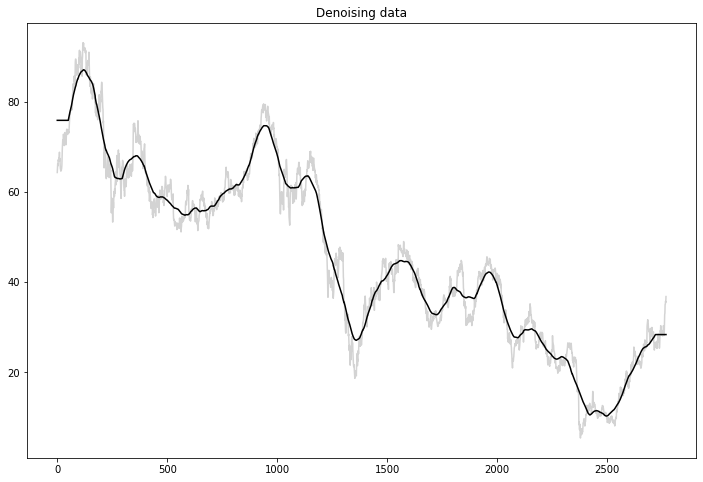

In [ ]:
dfs = pd.read_csv("DVN.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.15, .1, .05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values) 
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "DVN", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.15
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6715 - accuracy: 0.6130 - val_loss: 0.6294 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6660 - accuracy: 0.6189 - val_loss: 0.6437 - val_accuracy: 0.6878
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5311 - accuracy: 0.7485 - val_loss: 0.6436 - val_accuracy: 0.6898
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4003 - accuracy: 0.8207 - val_loss: 0.5683 - val_accuracy: 0.6653
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3705 - accuracy: 0.8337 - val_loss: 0.7807 - val_accuracy: 0.6939
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6683 - accuracy: 0.6172 - val_loss: 0.6364 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_cross.to_csv('DVN_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.15,DVN,0.511450,0.693878,0.471831,0.437908
1,GRU 0.15,DVN,0.553571,0.712245,0.467925,0.405229
2,XGBoost 0.15,DVN,0.496774,0.685714,0.500000,0.503268
3,Logreg 0.15,DVN,0.566038,0.716327,0.463320,0.392157
4,SVM 0.15,DVN,0.493333,0.683673,0.488449,0.483660
5,LSTM beta 0.15,DVN,0.441860,0.704595,0.457831,0.475000
6,GRU beta 0.15,DVN,0.405405,0.676149,0.447761,0.500000
7,XGBoost beta 0.15,DVN,0.431034,0.684902,0.510204,0.625000
8,logreg beta 0.15,DVN,0.438462,0.702407,0.456000,0.475000
9,svm beta 0.15,DVN,0.410596,0.678337,0.457565,0.516667


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
 
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "DVN", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.15
start lstm training...

Epoch 1/5
106/106 [==============================] - 4s 19ms/step - loss: 0.6679 - accuracy: 0.6136 - val_loss: 0.6348 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6590 - accuracy: 0.6189 - val_loss: 0.5904 - val_accuracy: 0.6878
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5634 - accuracy: 0.7059 - val_loss: 0.6361 - val_accuracy: 0.6878
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4851 - accuracy: 0.7686 - val_loss: 0.7454 - val_accuracy: 0.6898
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3586 - accuracy: 0.8450 - val_loss: 0.5929 - val_accuracy: 0.6898
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6638 - accuracy: 0.6142 - val_loss: 0.5958 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_purging.to_csv('DVN_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.15,DVN,0.503546,0.689796,0.482993,0.464052
1,GRU 0.15,DVN,0.493333,0.683673,0.488449,0.483660
2,XGBoost 0.15,DVN,0.496774,0.685714,0.500000,0.503268
3,Logreg 0.15,DVN,0.566038,0.716327,0.463320,0.392157
4,SVM 0.15,DVN,0.493333,0.683673,0.488449,0.483660
5,LSTM beta 0.15,DVN,0.421687,0.680525,0.489510,0.583333
6,GRU beta 0.15,DVN,0.404110,0.676149,0.443609,0.491667
7,XGBoost beta 0.15,DVN,0.431034,0.684902,0.510204,0.625000
8,logreg beta 0.15,DVN,0.438462,0.702407,0.456000,0.475000
9,svm beta 0.15,DVN,0.410596,0.678337,0.457565,0.516667


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg_beta_p.csv')

## RMD

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.RMD,D,20101004,0,32.830,32.870,32.28,32.468818,416669
1,US1.RMD,D,20101005,0,32.650,33.205,32.65,32.468818,653616
2,US1.RMD,D,20101006,0,33.240,33.460,33.16,32.468818,589273
3,US1.RMD,D,20101007,0,33.330,33.330,32.59,32.468818,328524
4,US1.RMD,D,20101008,0,32.650,33.030,32.43,32.468818,689901
...,...,...,...,...,...,...,...,...,...
2764,US1.RMD,D,20210927,0,277.170,277.170,268.44,279.909800,7537
2765,US1.RMD,D,20210928,0,265.150,266.290,262.26,279.909800,15954
2766,US1.RMD,D,20210929,0,264.905,266.600,263.85,279.909800,15648
2767,US1.RMD,D,20210930,0,268.770,269.040,263.96,279.909800,7497


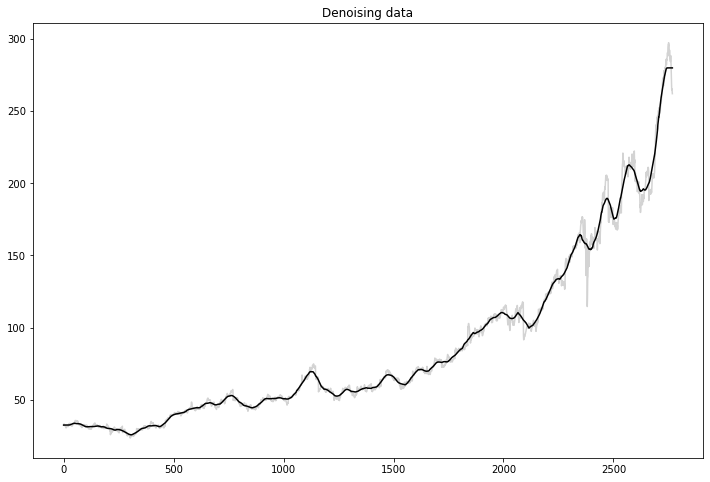

In [ ]:
dfs = pd.read_csv("RMD.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', 50)
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "RMD", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 8s 14ms/step - loss: 0.6128 - accuracy: 0.7077 - val_loss: 0.5634 - val_accuracy: 0.7510
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6087 - accuracy: 0.7107 - val_loss: 0.5701 - val_accuracy: 0.7510
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6048 - accuracy: 0.7107 - val_loss: 0.5566 - val_accuracy: 0.7510
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5093 - accuracy: 0.7527 - val_loss: 0.3529 - val_accuracy: 0.8673
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4168 - accuracy: 0.8207 - val_loss: 0.3320 - val_accuracy: 0.8653
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6123 - accuracy: 0.7077 - val_loss: 0.5751 - val_accuracy: 0.7510
Epoch 2/5
106/106 [==============================] - 1s 9ms/step -

In [ ]:
Result_cross.to_csv('RMD_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.05,RMD,0.859524,0.865306,0.916244,0.980978
1,GRU 0.05,RMD,0.855450,0.861224,0.913924,0.980978
2,XGBoost 0.05,RMD,0.878935,0.887755,0.929577,0.986413
3,Logreg 0.05,RMD,0.809313,0.818367,0.891331,0.991848
4,SVM 0.05,RMD,0.852804,0.865306,0.917085,0.991848
5,LSTM beta 0.05,RMD,0.821244,0.809628,0.879334,0.946269
6,GRU beta 0.05,RMD,0.796610,0.803063,0.879679,0.982090
7,XGBoost beta 0.05,RMD,0.809877,0.816193,0.886486,0.979104
8,logreg beta 0.05,RMD,0.807980,0.807440,0.880435,0.967164
9,svm beta 0.05,RMD,0.805419,0.809628,0.882591,0.976119


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "RMD", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.5265 - accuracy: 0.7987 - val_loss: 0.5781 - val_accuracy: 0.7510
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5066 - accuracy: 0.8047 - val_loss: 0.5644 - val_accuracy: 0.7510
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5007 - accuracy: 0.8047 - val_loss: 0.5628 - val_accuracy: 0.7510
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4998 - accuracy: 0.8047 - val_loss: 0.5739 - val_accuracy: 0.7510
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4975 - accuracy: 0.8047 - val_loss: 0.5655 - val_accuracy: 0.7510
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.5095 - accuracy: 0.8007 - val_loss: 0.5857 - val_accuracy: 0.7510
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4591

In [ ]:
Result_purging.to_csv('RMD_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.05,RMD,0.751020,0.751020,0.857809,1.000000
1,GRU 0.05,RMD,0.846868,0.859184,0.913642,0.991848
2,XGBoost 0.05,RMD,0.851163,0.865306,0.917293,0.994565
3,Logreg 0.05,RMD,0.751020,0.751020,0.857809,1.000000
4,SVM 0.05,RMD,0.844907,0.857143,0.912500,0.991848
5,LSTM beta 0.05,RMD,0.746575,0.739606,0.846054,0.976119
6,GRU beta 0.05,RMD,0.775414,0.776805,0.865435,0.979104
7,XGBoost beta 0.05,RMD,0.807882,0.814004,0.885290,0.979104
8,logreg beta 0.05,RMD,0.769412,0.768053,0.860526,0.976119
9,svm beta 0.05,RMD,0.776722,0.776805,0.865079,0.976119


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg_beta_p.csv')

## WU

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.WU,D,20101004,0,17.62,17.790,17.360,18.879175,4081478
1,US1.WU,D,20101005,0,17.56,17.990,17.400,18.879175,5231417
2,US1.WU,D,20101006,0,17.99,18.000,17.570,18.879175,3513358
3,US1.WU,D,20101007,0,17.77,17.820,17.540,18.879175,3231681
4,US1.WU,D,20101008,0,17.62,17.780,17.500,18.879175,2250995
...,...,...,...,...,...,...,...,...,...
2764,US1.WU,D,20210927,0,20.94,20.940,20.450,22.843950,157910
2765,US1.WU,D,20210928,0,20.82,21.130,20.755,22.843950,160902
2766,US1.WU,D,20210929,0,20.86,20.950,20.660,22.843950,65787
2767,US1.WU,D,20210930,0,20.83,20.870,20.215,22.843950,155988


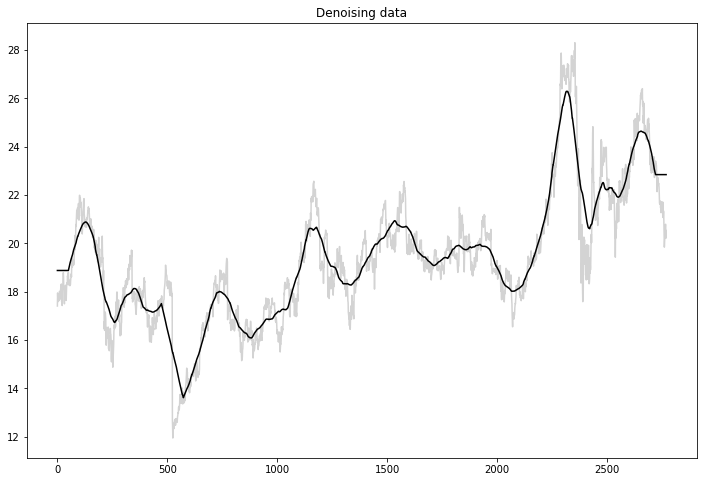

In [ ]:
dfs = pd.read_csv("WU.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.1, .05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "WU", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6788 - accuracy: 0.5953 - val_loss: 0.6952 - val_accuracy: 0.5245
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6768 - accuracy: 0.5994 - val_loss: 0.6976 - val_accuracy: 0.5245
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6757 - accuracy: 0.5994 - val_loss: 0.6980 - val_accuracy: 0.5245
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6729 - accuracy: 0.5994 - val_loss: 0.6523 - val_accuracy: 0.6490
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6222 - accuracy: 0.6609 - val_loss: 0.4903 - val_accuracy: 0.8224
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6759 - accuracy: 0.5775 - val_loss: 0.7144 - val_accuracy: 0.5245
Epoch 2/5
106/106 [==============================] - 1s 9ms/step - 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6912 - accuracy: 0.5278 - val_loss: 0.6924 - val_accuracy: 0.5245
Epoch 2/5
106/106 [==============================] - 1s 9ms/step - loss: 0.6144 - accuracy: 0.6260 - val_loss: 0.4489 - val_accuracy: 0.7612
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3280 - accuracy: 0.8734 - val_loss: 0.3164 - val_accuracy: 0.8265
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3135 - accuracy: 0.8675 - val_loss: 0.2735 - val_accuracy: 0.8551
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3050 - accuracy: 0.8775 - val_loss: 0.2427 - val_accuracy: 0.8939
end training. 

start xgboost training...

[0]	validation_0-auc:0.938069
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.93928
[2]	validation_0-auc:0.941843
[3]	validation_0-auc:0.943404
[4]	validation_0-auc:0.944

In [ ]:
Result_cross.to_csv('WU_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,WU,0.753472,0.822449,0.833013,0.931330
1,GRU 0.1,WU,0.792727,0.853061,0.858268,0.935622
2,XGBoost 0.1,WU,0.880184,0.861224,0.848889,0.819742
3,Logreg 0.1,WU,1.000000,0.873469,0.846535,0.733906
4,SVM 0.1,WU,0.853755,0.889796,0.888889,0.927039
5,LSTM beta 0.1,WU,1.000000,0.908096,0.900943,0.819742
6,GRU beta 0.1,WU,1.000000,0.916849,0.911215,0.836910
7,XGBoost beta 0.1,WU,0.828194,0.816193,0.817391,0.806867
8,logreg beta 0.1,WU,1.000000,0.886214,0.874396,0.776824
9,svm beta 0.1,WU,1.000000,0.921225,0.916279,0.845494


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "WU", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6920 - accuracy: 0.5450 - val_loss: 0.6935 - val_accuracy: 0.5245
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6886 - accuracy: 0.5564 - val_loss: 0.6918 - val_accuracy: 0.5245
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6881 - accuracy: 0.5564 - val_loss: 0.6932 - val_accuracy: 0.5245
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6871 - accuracy: 0.5584 - val_loss: 0.6911 - val_accuracy: 0.5245
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6876 - accuracy: 0.5570 - val_loss: 0.6898 - val_accuracy: 0.5245


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6907 - accuracy: 0.5537 - val_loss: 0.6877 - val_accuracy: 0.5245
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6787 - accuracy: 0.5644 - val_loss: 0.6458 - val_accuracy: 0.8918
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4674 - accuracy: 0.7906 - val_loss: 0.2620 - val_accuracy: 0.8878
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.3603 - accuracy: 0.8329 - val_loss: 0.2496 - val_accuracy: 0.9082
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.3513 - accuracy: 0.8383 - val_loss: 0.2325 - val_accuracy: 0.8939
end training. 

start xgboost training...

[0]	validation_0-auc:0.940691
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.94682
[2]	validation_0-auc:0.94641
[3]	validation_0-auc:0.946277
[4]	validation_0-auc:0.9456
[5]	vali

In [ ]:
Result_purging.to_csv('WU_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,WU,0.000000,0.524490,0.000000,0.000000
1,GRU 0.1,WU,0.933014,0.893878,0.882353,0.836910
2,XGBoost 0.1,WU,0.906542,0.879592,0.868009,0.832618
3,Logreg 0.1,WU,1.000000,0.891837,0.871671,0.772532
4,SVM 0.1,WU,0.847059,0.885714,0.885246,0.927039
5,LSTM beta 0.1,WU,1.000000,0.890591,0.879808,0.785408
6,GRU beta 0.1,WU,0.796154,0.827133,0.839757,0.888412
7,XGBoost beta 0.1,WU,0.932642,0.855580,0.845070,0.772532
8,logreg beta 0.1,WU,1.000000,0.914661,0.908665,0.832618
9,svm beta 0.1,WU,0.994949,0.919037,0.914153,0.845494


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg_beta_p.csv')

## AMT

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.AMT,D,20101004,0,51.59,51.84,50.855,50.9896,2776426
1,US1.AMT,D,20101005,0,51.43,52.34,51.390,50.9896,2281804
2,US1.AMT,D,20101006,0,51.94,52.05,50.310,50.9896,3568106
3,US1.AMT,D,20101007,0,51.03,51.63,50.310,50.9896,3668859
4,US1.AMT,D,20101008,0,50.53,50.56,50.130,50.9896,2086997
...,...,...,...,...,...,...,...,...,...
2762,US1.AMT,D,20210927,0,280.62,280.71,273.670,289.3756,59047
2763,US1.AMT,D,20210928,0,271.08,271.81,266.860,289.3756,76212
2764,US1.AMT,D,20210929,0,269.10,271.24,268.440,289.3756,43260
2765,US1.AMT,D,20210930,0,271.80,272.14,265.300,289.3756,50333


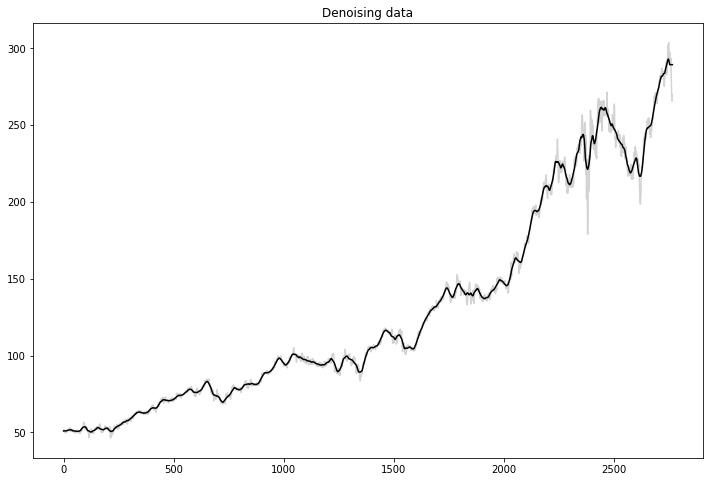

In [ ]:
dfs = pd.read_csv("AMT.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=25)
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
 
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMT", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

In [ ]:
Result_cross.to_csv('AMT_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,AMT,0.000000,0.873469,0.000000,0.000000
1,GRU 0.1,AMT,1.000000,0.881633,0.121212,0.064516
2,XGBoost 0.1,AMT,0.393258,0.834694,0.463576,0.564516
3,Logreg 0.1,AMT,0.581395,0.887755,0.476190,0.403226
4,SVM 0.1,AMT,0.535714,0.881633,0.508475,0.483871
5,LSTM beta 0.1,AMT,0.000000,0.864333,0.000000,0.000000
6,GRU beta 0.1,AMT,0.561644,0.884026,0.607407,0.661290
7,XGBoost beta 0.1,AMT,0.333333,0.778993,0.435754,0.629032
8,logreg beta 0.1,AMT,0.406593,0.827133,0.483660,0.596774
9,svm beta 0.1,AMT,0.271845,0.761488,0.339394,0.451613


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMT", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6624 - accuracy: 0.6409 - val_loss: 0.5089 - val_accuracy: 0.8735
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6549 - accuracy: 0.6430 - val_loss: 0.5227 - val_accuracy: 0.8735
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6500 - accuracy: 0.6423 - val_loss: 0.5266 - val_accuracy: 0.8735
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6328 - accuracy: 0.6644 - val_loss: 0.4690 - val_accuracy: 0.8735
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6200 - accuracy: 0.6846 - val_loss: 0.4383 - val_accuracy: 0.8796
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 17ms/step - loss: 0.6606 - accuracy: 0.6430 - val_loss: 0.5285 - val_accuracy: 0.8735
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6510 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 2s 13ms/step - loss: 0.5514 - accuracy: 0.7765 - val_loss: 0.4112 - val_accuracy: 0.8735
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5332 - accuracy: 0.7805 - val_loss: 0.4025 - val_accuracy: 0.8735
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5306 - accuracy: 0.7805 - val_loss: 0.3941 - val_accuracy: 0.8735
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5232 - accuracy: 0.7819 - val_loss: 0.3749 - val_accuracy: 0.8735
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5182 - accuracy: 0.7805 - val_loss: 0.3700 - val_accuracy: 0.8735
end training. 

start xgboost training...

[0]	validation_0-auc:0.76383
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.790436
[2]	validation_0-auc:0.78955
[3]	validation_0-auc:0.806508
[4]	validation_0-auc:0.802438
[5]	va

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



start lstm beta training...

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.5474 - accuracy: 0.7749 - val_loss: 0.4342 - val_accuracy: 0.8643
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.5453 - accuracy: 0.7756 - val_loss: 0.4287 - val_accuracy: 0.8643
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.5402 - accuracy: 0.7756 - val_loss: 0.4154 - val_accuracy: 0.8643
Epoch 4/5
92/92 [==============================] - 1s 10ms/step - loss: 0.5397 - accuracy: 0.7756 - val_loss: 0.4224 - val_accuracy: 0.8643
Epoch 5/5
92/92 [==============================] - 1s 10ms/step - loss: 0.5371 - accuracy: 0.7756 - val_loss: 0.4116 - val_accuracy: 0.8643
end training. 

start gru beta training...

Epoch 1/5
92/92 [==============================] - 3s 13ms/step - loss: 0.5533 - accuracy: 0.7742 - val_loss: 0.4162 - val_accuracy: 0.8643
Epoch 2/5
92/92 [==============================] - 1s 9ms/step - loss: 0.5392 - accurac

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6176 - accuracy: 0.6933 - val_loss: 0.5102 - val_accuracy: 0.8735
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6046 - accuracy: 0.7054 - val_loss: 0.3833 - val_accuracy: 0.8735
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5913 - accuracy: 0.7174 - val_loss: 0.4165 - val_accuracy: 0.8816
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5762 - accuracy: 0.7248 - val_loss: 0.4081 - val_accuracy: 0.8857
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5754 - accuracy: 0.7255 - val_loss: 0.4071 - val_accuracy: 0.8878
end training. 

start xgboost training...

[0]	validation_0-auc:0.689478
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.721228
[2]	validation_0-auc:0.722773
[3]	validation_0-auc:0.755653
[4]	validation_0-auc:0.765658
[5]	

In [ ]:
Result_purging.to_csv('AMT_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,AMT,1.000000,0.879592,0.092308,0.048387
1,GRU 0.1,AMT,0.527273,0.879592,0.495726,0.467742
2,XGBoost 0.1,AMT,0.393258,0.834694,0.463576,0.564516
3,Logreg 0.1,AMT,0.581395,0.887755,0.476190,0.403226
4,SVM 0.1,AMT,0.535714,0.881633,0.508475,0.483871
5,LSTM beta 0.1,AMT,0.478723,0.855580,0.576923,0.725806
6,GRU beta 0.1,AMT,0.443182,0.842451,0.520000,0.629032
7,XGBoost beta 0.1,AMT,0.333333,0.778993,0.435754,0.629032
8,logreg beta 0.1,AMT,0.406593,0.827133,0.483660,0.596774
9,svm beta 0.1,AMT,0.271845,0.761488,0.339394,0.451613


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg_beta_p.csv')

## CL

In [ ]:
dfs = pd.read_csv("CL.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.CL,D,20101004,0,76.46,77.24,76.25,77.916262,2872127
1,US1.CL,D,20101005,0,75.90,76.10,74.40,77.916262,7170535
2,US1.CL,D,20101006,0,74.73,75.04,73.75,77.916262,4674296
3,US1.CL,D,20101007,0,74.63,74.63,73.67,77.916262,3563991
4,US1.CL,D,20101008,0,73.77,75.04,73.62,77.916262,3042250
...,...,...,...,...,...,...,...,...,...
2764,US1.CL,D,20210927,0,76.58,76.65,75.92,80.566900,144858
2765,US1.CL,D,20210928,0,75.79,76.15,75.41,80.566900,227270
2766,US1.CL,D,20210929,0,75.89,77.35,75.72,80.566900,244930
2767,US1.CL,D,20210930,0,77.24,77.24,75.59,80.566900,208601


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "CL", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6860 - accuracy: 0.5738 - val_loss: 0.6342 - val_accuracy: 0.8327
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6841 - accuracy: 0.5745 - val_loss: 0.6326 - val_accuracy: 0.8327
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6845 - accuracy: 0.5725 - val_loss: 0.6040 - val_accuracy: 0.8327
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6775 - accuracy: 0.5765 - val_loss: 0.5790 - val_accuracy: 0.8224
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6670 - accuracy: 0.5987 - val_loss: 0.6031 - val_accuracy: 0.8367
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6894 - accuracy: 0.5570 - val_loss: 0.5776 - val_accuracy: 0.8265
Epoch 2/5
94/94 [==============================] - 1s 9ms/step - loss: 0.6771 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 2s 13ms/step - loss: 0.4538 - accuracy: 0.8463 - val_loss: 0.2953 - val_accuracy: 0.9490
Epoch 2/5
94/94 [==============================] - 1s 9ms/step - loss: 0.4366 - accuracy: 0.8490 - val_loss: 0.2641 - val_accuracy: 0.9490
Epoch 3/5
94/94 [==============================] - 1s 9ms/step - loss: 0.4269 - accuracy: 0.8490 - val_loss: 0.2257 - val_accuracy: 0.9429
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4301 - accuracy: 0.8490 - val_loss: 0.3445 - val_accuracy: 0.9367
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4214 - accuracy: 0.8490 - val_loss: 0.2469 - val_accuracy: 0.9388
end training. 

start xgboost training...

[0]	validation_0-auc:0.631355
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.631398
[2]	validation_0-auc:0.629763
[3]	validation_0-auc:0.667613
[4]	validation_0-auc:0.668645
[5]	va

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



start lstm beta training...

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.4568 - accuracy: 0.8428 - val_loss: 0.2789 - val_accuracy: 0.9453
Epoch 2/5
92/92 [==============================] - 1s 11ms/step - loss: 0.4439 - accuracy: 0.8456 - val_loss: 0.2507 - val_accuracy: 0.9453
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4375 - accuracy: 0.8456 - val_loss: 0.2647 - val_accuracy: 0.9453
Epoch 4/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4398 - accuracy: 0.8456 - val_loss: 0.2634 - val_accuracy: 0.9453
Epoch 5/5
92/92 [==============================] - 1s 11ms/step - loss: 0.4381 - accuracy: 0.8456 - val_loss: 0.2546 - val_accuracy: 0.9453


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
92/92 [==============================] - 2s 13ms/step - loss: 0.4662 - accuracy: 0.8442 - val_loss: 0.2623 - val_accuracy: 0.9453
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4405 - accuracy: 0.8456 - val_loss: 0.2478 - val_accuracy: 0.9453
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4309 - accuracy: 0.8456 - val_loss: 0.2983 - val_accuracy: 0.8972
Epoch 4/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4163 - accuracy: 0.8463 - val_loss: 0.3448 - val_accuracy: 0.8796
Epoch 5/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4131 - accuracy: 0.8497 - val_loss: 0.3515 - val_accuracy: 0.8796
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.474259
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.474259
[2]	validation_0-auc:0.474074
[3]	validation_0-auc:0.474074
[4]	validation_0-auc:0.4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6506 - accuracy: 0.6490 - val_loss: 0.4890 - val_accuracy: 0.9490
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6505 - accuracy: 0.6537 - val_loss: 0.4716 - val_accuracy: 0.9490
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6484 - accuracy: 0.6537 - val_loss: 0.4499 - val_accuracy: 0.9490
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6463 - accuracy: 0.6537 - val_loss: 0.4410 - val_accuracy: 0.9490
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6468 - accuracy: 0.6537 - val_loss: 0.4417 - val_accuracy: 0.9490


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 2s 13ms/step - loss: 0.6550 - accuracy: 0.6503 - val_loss: 0.4339 - val_accuracy: 0.9490
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6462 - accuracy: 0.6537 - val_loss: 0.4675 - val_accuracy: 0.9388
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6401 - accuracy: 0.6537 - val_loss: 0.4431 - val_accuracy: 0.9347
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6204 - accuracy: 0.6698 - val_loss: 0.3973 - val_accuracy: 0.9265
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6124 - accuracy: 0.6846 - val_loss: 0.4005 - val_accuracy: 0.9143
end training. 

start xgboost training...

[0]	validation_0-auc:0.791785
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.812774
[2]	validation_0-auc:0.837505
[3]	validation_0-auc:0.840903
[4]	validation_0-auc:0.843097
[5]	

In [ ]:
Result_cross.to_csv('CL_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,CL,0.512195,0.836735,0.512195,0.512195
1,GRU 0.1,CL,0.555556,0.846939,0.482759,0.426829
2,XGBoost 0.1,CL,0.428571,0.800000,0.494845,0.585366
3,Logreg 0.1,CL,0.448598,0.810204,0.507937,0.585366
4,SVM 0.1,CL,0.476190,0.824490,0.481928,0.487805
5,LSTM beta 0.1,CL,0.344828,0.763676,0.425532,0.555556
6,GRU beta 0.1,CL,0.401408,0.781182,0.532710,0.791667
7,XGBoost beta 0.1,CL,0.525773,0.853392,0.603550,0.708333
8,logreg beta 0.1,CL,0.410256,0.796499,0.507937,0.666667
9,svm beta 0.1,CL,0.431193,0.809628,0.519337,0.652778


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "CL", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6883 - accuracy: 0.5544 - val_loss: 0.6046 - val_accuracy: 0.8327
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6823 - accuracy: 0.5745 - val_loss: 0.6078 - val_accuracy: 0.8265
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6754 - accuracy: 0.5906 - val_loss: 0.5504 - val_accuracy: 0.8184
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6761 - accuracy: 0.5752 - val_loss: 0.5590 - val_accuracy: 0.8449
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6552 - accuracy: 0.6060 - val_loss: 0.6935 - val_accuracy: 0.5102
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6864 - accuracy: 0.5631 - val_loss: 0.6243 - val_accuracy: 0.8204
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6735 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.4610 - accuracy: 0.8409 - val_loss: 0.2818 - val_accuracy: 0.9490
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4419 - accuracy: 0.8490 - val_loss: 0.3098 - val_accuracy: 0.9490
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4254 - accuracy: 0.8490 - val_loss: 0.2663 - val_accuracy: 0.9408
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4221 - accuracy: 0.8490 - val_loss: 0.2528 - val_accuracy: 0.9367
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4152 - accuracy: 0.8503 - val_loss: 0.3438 - val_accuracy: 0.9347
end training. 

start xgboost training...

[0]	validation_0-auc:0.631355
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.631398
[2]	validation_0-auc:0.629763
[3]	validation_0-auc:0.667613
[4]	validation_0-auc:0.668645
[5]	

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



start lstm beta training...

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.4676 - accuracy: 0.8428 - val_loss: 0.2832 - val_accuracy: 0.9453
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4419 - accuracy: 0.8456 - val_loss: 0.2936 - val_accuracy: 0.9453
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4514 - accuracy: 0.8456 - val_loss: 0.2437 - val_accuracy: 0.9453
Epoch 4/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4473 - accuracy: 0.8456 - val_loss: 0.2702 - val_accuracy: 0.9453
Epoch 5/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4284 - accuracy: 0.8456 - val_loss: 0.2894 - val_accuracy: 0.9453


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.4662 - accuracy: 0.8428 - val_loss: 0.2343 - val_accuracy: 0.9453
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4384 - accuracy: 0.8456 - val_loss: 0.2766 - val_accuracy: 0.9059
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4264 - accuracy: 0.8456 - val_loss: 0.3505 - val_accuracy: 0.8862
Epoch 4/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4145 - accuracy: 0.8524 - val_loss: 0.3957 - val_accuracy: 0.8796
Epoch 5/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4125 - accuracy: 0.8476 - val_loss: 0.4261 - val_accuracy: 0.8796
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.474259
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.474259
[2]	validation_0-auc:0.474074
[3]	validation_0-auc:0.474074
[4]	validation_0-auc:0.4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6513 - accuracy: 0.6477 - val_loss: 0.5052 - val_accuracy: 0.9490
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6505 - accuracy: 0.6537 - val_loss: 0.4315 - val_accuracy: 0.9490
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6466 - accuracy: 0.6537 - val_loss: 0.5670 - val_accuracy: 0.9490
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6485 - accuracy: 0.6517 - val_loss: 0.4457 - val_accuracy: 0.9490
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6415 - accuracy: 0.6550 - val_loss: 0.4451 - val_accuracy: 0.9306
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6501 - accuracy: 0.6537 - val_loss: 0.5251 - val_accuracy: 0.9388
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6463 - accuracy: 0.6564

In [ ]:
Result_purging.to_csv('CL_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,CL,0.238411,0.510204,0.375000,0.878049
1,GRU 0.1,CL,0.366864,0.740816,0.494024,0.756098
2,XGBoost 0.1,CL,0.428571,0.800000,0.494845,0.585366
3,Logreg 0.1,CL,0.448598,0.810204,0.507937,0.585366
4,SVM 0.1,CL,0.476190,0.824490,0.481928,0.487805
5,LSTM beta 0.1,CL,0.270833,0.794311,0.216667,0.180556
6,GRU beta 0.1,CL,0.446602,0.818381,0.525714,0.638889
7,XGBoost beta 0.1,CL,0.525773,0.853392,0.603550,0.708333
8,logreg beta 0.1,CL,0.410256,0.796499,0.507937,0.666667
9,svm beta 0.1,CL,0.431193,0.809628,0.519337,0.652778


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg_beta_p.csv')

## CPRI

In [ ]:
dfs = pd.read_csv("CPRI.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2464,US1.CPRI,D,20211001,0,48.61,50.18,47.93,49.78,37955
1,2463,US1.CPRI,D,20210930,0,50.23,50.73,48.33,48.40,51156
2,2462,US1.CPRI,D,20210929,0,52.41,52.96,51.17,51.19,16510
3,2461,US1.CPRI,D,20210928,0,53.13,53.13,52.07,52.50,15965
4,2460,US1.CPRI,D,20210927,0,52.69,53.40,52.69,52.99,43844
...,...,...,...,...,...,...,...,...,...,...
2460,4,US1.CPRI,D,20111221,0,25.64,26.78,25.46,26.50,2485638
2461,3,US1.CPRI,D,20111220,0,25.02,25.76,25.02,25.40,1697064
2462,2,US1.CPRI,D,20111219,0,24.50,25.09,24.31,24.83,3133441
2463,1,US1.CPRI,D,20111216,0,24.45,24.80,23.51,24.21,3921157


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2100)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "CPRI", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6860 - accuracy: 0.5685 - val_loss: 0.7166 - val_accuracy: 0.3621
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6553 - accuracy: 0.5953 - val_loss: 0.6748 - val_accuracy: 0.4724
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6304 - accuracy: 0.6564 - val_loss: 0.6339 - val_accuracy: 0.7207
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6199 - accuracy: 0.6651 - val_loss: 0.5717 - val_accuracy: 0.7552
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6036 - accuracy: 0.6738 - val_loss: 0.7500 - val_accuracy: 0.5138
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6854 - accuracy: 0.5671 - val_loss: 0.7362 - val_accuracy: 0.3621
Epoch 2/5
94/94 [==============================] - 1s 9ms/step - loss: 0.6409 -

In [ ]:
Result_cross.to_csv('CPRI_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,CPRI,0.423077,0.513793,0.584071,0.942857
1,GRU 0.1,CPRI,0.576923,0.720690,0.689655,0.857143
2,XGBoost 0.1,CPRI,0.567742,0.710345,0.676923,0.838095
3,Logreg 0.1,CPRI,0.513514,0.655172,0.655172,0.904762
4,SVM 0.1,CPRI,0.550296,0.696552,0.678832,0.885714
5,LSTM beta 0.1,CPRI,0.590164,0.762646,0.541353,0.500000
6,GRU beta 0.1,CPRI,0.661017,0.793774,0.595420,0.541667
7,XGBoost beta 0.1,CPRI,0.366071,0.603113,0.445652,0.569444
8,logreg beta 0.1,CPRI,0.451613,0.673152,0.571429,0.777778
9,svm beta 0.1,CPRI,0.439024,0.680934,0.467532,0.500000


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2100)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "CPRI", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6806 - accuracy: 0.5678 - val_loss: 0.6912 - val_accuracy: 0.4448
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6543 - accuracy: 0.6107 - val_loss: 0.6448 - val_accuracy: 0.6241
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6132 - accuracy: 0.6685 - val_loss: 0.6168 - val_accuracy: 0.6690
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5873 - accuracy: 0.6933 - val_loss: 0.6643 - val_accuracy: 0.5345
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5932 - accuracy: 0.6718 - val_loss: 0.5984 - val_accuracy: 0.6897
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6597 - accuracy: 0.6148 - val_loss: 0.6102 - val_accuracy: 0.7310
Epoch 2/5
94/94 [==============================] - 1s 9ms/step - loss: 0.5914 -

In [ ]:
Result_purging.to_csv('CPRI_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,CPRI,0.553648,0.716327,0.649874,0.786585
1,GRU 0.1,CPRI,0.493103,0.657143,0.629956,0.871951
2,XGBoost 0.1,CPRI,0.513410,0.679592,0.630588,0.817073
3,Logreg 0.1,CPRI,0.491694,0.655102,0.636559,0.902439
4,SVM 0.1,CPRI,0.512545,0.679592,0.645598,0.871951
5,LSTM beta 0.1,CPRI,0.368132,0.608315,0.428115,0.511450
6,GRU beta 0.1,CPRI,0.517241,0.724289,0.543478,0.572519
7,XGBoost beta 0.1,CPRI,0.348416,0.566740,0.437500,0.587786
8,logreg beta 0.1,CPRI,0.440000,0.654267,0.556180,0.755725
9,svm beta 0.1,CPRI,0.398810,0.638950,0.448161,0.511450


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2100].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg_beta_p.csv')

## FCX

In [ ]:
dfs = pd.read_csv("FCX.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2768,US1.FCX,D,20211001,0,33.00,33.100,31.8700,32.8400,805504
1,2767,US1.FCX,D,20210930,0,32.69,33.750,32.5300,32.5400,1359849
2,2766,US1.FCX,D,20210929,0,34.00,34.010,32.9200,33.1000,589350
3,2765,US1.FCX,D,20210928,0,33.98,34.015,32.8200,33.5700,910310
4,2764,US1.FCX,D,20210927,0,32.29,33.950,32.2900,33.9000,1099291
...,...,...,...,...,...,...,...,...,...,...
2764,4,US1.FCX,D,20101008,0,92.31,95.910,92.0002,95.5200,12656521
2765,3,US1.FCX,D,20101007,0,93.63,93.870,89.8500,91.3975,13153770
2766,2,US1.FCX,D,20101006,0,91.51,94.360,91.4500,93.6100,13105657
2767,1,US1.FCX,D,20101005,0,88.71,91.800,88.6100,91.1800,12610936


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "FCX", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6893 - accuracy: 0.5477 - val_loss: 0.7204 - val_accuracy: 0.3918
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6373 - accuracy: 0.6376 - val_loss: 0.7106 - val_accuracy: 0.5143
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5980 - accuracy: 0.6799 - val_loss: 0.6251 - val_accuracy: 0.6327
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5338 - accuracy: 0.7463 - val_loss: 0.5662 - val_accuracy: 0.7041
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5255 - accuracy: 0.7510 - val_loss: 0.5858 - val_accuracy: 0.6816
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6122 - accuracy: 0.6530 - val_loss: 0.5663 - val_accuracy: 0.7143
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5236 

In [ ]:
Result_cross.to_csv('FCX_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,FCX,0.570866,0.681633,0.650224,0.755208
1,GRU 0.1,FCX,0.510386,0.622449,0.650284,0.895833
2,XGBoost 0.1,FCX,0.533113,0.648980,0.651822,0.838542
3,Logreg 0.1,FCX,0.538462,0.655102,0.655804,0.838542
4,SVM 0.1,FCX,0.545455,0.663265,0.662577,0.843750
5,LSTM beta 0.1,FCX,0.508834,0.619256,0.623377,0.804469
6,GRU beta 0.1,FCX,0.484099,0.588621,0.593074,0.765363
7,XGBoost beta 0.1,FCX,0.479452,0.582057,0.594480,0.782123
8,logreg beta 0.1,FCX,0.510345,0.621444,0.631130,0.826816
9,svm beta 0.1,FCX,0.521127,0.634573,0.639309,0.826816


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "FCX", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6878 - accuracy: 0.5483 - val_loss: 0.7010 - val_accuracy: 0.3918
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6269 - accuracy: 0.6718 - val_loss: 0.5939 - val_accuracy: 0.6633
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5853 - accuracy: 0.7074 - val_loss: 0.5955 - val_accuracy: 0.6592
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5343 - accuracy: 0.7403 - val_loss: 0.5591 - val_accuracy: 0.7163
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5134 - accuracy: 0.7557 - val_loss: 0.6455 - val_accuracy: 0.6224
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6332 - accuracy: 0.6430 - val_loss: 0.6509 - val_accuracy: 0.5776
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5276 

In [ ]:
Result_purging.to_csv('FCX_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,FCX,0.510638,0.622449,0.644914,0.875000
1,GRU 0.1,FCX,0.505952,0.616327,0.643939,0.885417
2,XGBoost 0.1,FCX,0.533113,0.648980,0.651822,0.838542
3,Logreg 0.1,FCX,0.538462,0.655102,0.655804,0.838542
4,SVM 0.1,FCX,0.545455,0.663265,0.662577,0.843750
5,LSTM beta 0.1,FCX,0.528846,0.634573,0.568475,0.614525
6,GRU beta 0.1,FCX,0.512605,0.621444,0.585132,0.681564
7,XGBoost beta 0.1,FCX,0.479452,0.582057,0.594480,0.782123
8,logreg beta 0.1,FCX,0.510345,0.621444,0.631130,0.826816
9,svm beta 0.1,FCX,0.521127,0.634573,0.639309,0.826816


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg_beta_p.csv')

## FOX

In [ ]:
dfs = pd.read_csv("FOX.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2756,US1.FOX,D,20211001,0,37.48,37.92,37.13,37.69,25772
1,2755,US1.FOX,D,20210930,0,37.90,37.99,37.11,37.13,49472
2,2754,US1.FOX,D,20210929,0,36.79,37.32,36.66,37.25,29082
3,2753,US1.FOX,D,20210928,0,36.99,37.35,36.76,36.86,31023
4,2752,US1.FOX,D,20210927,0,36.38,37.19,36.38,36.93,34743
...,...,...,...,...,...,...,...,...,...,...
2752,4,US1.FOX,D,20101008,0,15.64,15.85,15.54,15.79,1297198
2753,3,US1.FOX,D,20101007,0,15.61,15.71,15.33,15.62,2236400
2754,2,US1.FOX,D,20101006,0,15.56,15.67,15.41,15.56,2451013
2755,1,US1.FOX,D,20101005,0,15.34,15.58,15.24,15.49,2117362


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOX", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6940 - accuracy: 0.5148 - val_loss: 0.7265 - val_accuracy: 0.1469
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6924 - accuracy: 0.5161 - val_loss: 0.6894 - val_accuracy: 0.5531
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6539 - accuracy: 0.6154 - val_loss: 0.5665 - val_accuracy: 0.7918
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6514 - accuracy: 0.6450 - val_loss: 0.6896 - val_accuracy: 0.6224
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6312 - accuracy: 0.6664 - val_loss: 0.7353 - val_accuracy: 0.6510
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6920 - accuracy: 0.5174 - val_loss: 0.7236 - val_accuracy: 0.2102
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6400 

In [ ]:
Result_cross.to_csv('FOX_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,FOX,0.263158,0.651020,0.391459,0.763889
1,GRU 0.1,FOX,0.281250,0.681633,0.409091,0.750000
2,XGBoost 0.1,FOX,0.278689,0.687755,0.400000,0.708333
3,Logreg 0.1,FOX,0.251163,0.634694,0.376307,0.750000
4,SVM 0.1,FOX,0.299492,0.691837,0.438662,0.819444
5,LSTM beta 0.1,FOX,0.181159,0.722101,0.282486,0.641026
6,GRU beta 0.1,FOX,0.172414,0.706783,0.271739,0.641026
7,XGBoost beta 0.1,FOX,0.149425,0.647702,0.244131,0.666667
8,logreg beta 0.1,FOX,0.158824,0.660832,0.258373,0.692308
9,svm beta 0.1,FOX,0.166667,0.625821,0.278481,0.846154


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOX", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6968 - accuracy: 0.4893 - val_loss: 0.7350 - val_accuracy: 0.1408
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6894 - accuracy: 0.5262 - val_loss: 0.8239 - val_accuracy: 0.1327
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6544 - accuracy: 0.6396 - val_loss: 0.5856 - val_accuracy: 0.7735
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6273 - accuracy: 0.6732 - val_loss: 0.7838 - val_accuracy: 0.4959
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6338 - accuracy: 0.6658 - val_loss: 0.6133 - val_accuracy: 0.7041
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6896 - accuracy: 0.5309 - val_loss: 0.7469 - val_accuracy: 0.2000
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6531 

In [ ]:
Result_purging.to_csv('FOX_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,FOX,0.284024,0.704082,0.398340,0.666667
1,GRU 0.1,FOX,0.246637,0.622449,0.372881,0.763889
2,XGBoost 0.1,FOX,0.278689,0.687755,0.400000,0.708333
3,Logreg 0.1,FOX,0.251163,0.634694,0.376307,0.750000
4,SVM 0.1,FOX,0.299492,0.691837,0.438662,0.819444
5,LSTM beta 0.1,FOX,0.118721,0.549234,0.201550,0.666667
6,GRU beta 0.1,FOX,0.187050,0.724289,0.292135,0.666667
7,XGBoost beta 0.1,FOX,0.149425,0.647702,0.244131,0.666667
8,logreg beta 0.1,FOX,0.158824,0.660832,0.258373,0.692308
9,svm beta 0.1,FOX,0.166667,0.625821,0.278481,0.846154


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg_beta_p.csv')

## FOXA

In [ ]:
dfs = pd.read_csv("FOXA.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2768,US1.FOXA,D,20211001,0,40.44,41.065,40.1200,40.79,76891
1,2767,US1.FOXA,D,20210930,0,40.75,41.060,40.1100,40.11,158785
2,2766,US1.FOXA,D,20210929,0,39.81,40.310,39.6500,40.24,91517
3,2765,US1.FOXA,D,20210928,0,39.87,40.420,39.7000,39.84,163999
4,2764,US1.FOXA,D,20210927,0,39.10,40.370,39.1000,40.11,180216
...,...,...,...,...,...,...,...,...,...,...
2764,4,US1.FOXA,D,20101008,0,13.68,13.950,13.5675,13.88,20812401
2765,3,US1.FOXA,D,20101007,0,13.48,13.750,13.3100,13.64,28318775
2766,2,US1.FOXA,D,20101006,0,13.58,13.650,13.3200,13.48,16218875
2767,1,US1.FOXA,D,20101005,0,13.28,13.580,13.1700,13.56,17732763


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOXA", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 18ms/step - loss: 0.6935 - accuracy: 0.5336 - val_loss: 0.6800 - val_accuracy: 0.8776
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6735 - accuracy: 0.5899 - val_loss: 0.7676 - val_accuracy: 0.1980
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6342 - accuracy: 0.6423 - val_loss: 0.5570 - val_accuracy: 0.7878
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6346 - accuracy: 0.6631 - val_loss: 0.6406 - val_accuracy: 0.6837
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6171 - accuracy: 0.6624 - val_loss: 0.5673 - val_accuracy: 0.7633
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6896 - accuracy: 0.5221 - val_loss: 0.8035 - val_accuracy: 0.1388
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6544 

In [ ]:
Result_cross.to_csv('FOXA_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,FOXA,0.340000,0.763265,0.467890,0.750000
1,GRU 0.1,FOXA,0.266667,0.646939,0.409556,0.882353
2,XGBoost 0.1,FOXA,0.315217,0.722449,0.460317,0.852941
3,Logreg 0.1,FOXA,0.259574,0.630612,0.402640,0.897059
4,SVM 0.1,FOXA,0.292929,0.693878,0.436090,0.852941
5,LSTM beta 0.1,FOXA,0.188235,0.538293,0.312704,0.923077
6,GRU beta 0.1,FOXA,0.226804,0.654267,0.357724,0.846154
7,XGBoost beta 0.1,FOXA,0.242775,0.691466,0.373333,0.807692
8,logreg beta 0.1,FOXA,0.271186,0.708972,0.419214,0.923077
9,svm beta 0.1,FOXA,0.236264,0.676149,0.367521,0.826923


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOXA", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6940 - accuracy: 0.5148 - val_loss: 0.7334 - val_accuracy: 0.1388
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 0.6830 - accuracy: 0.5497 - val_loss: 0.6837 - val_accuracy: 0.6204
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6416 - accuracy: 0.6477 - val_loss: 0.6966 - val_accuracy: 0.6286
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6243 - accuracy: 0.6577 - val_loss: 0.6314 - val_accuracy: 0.7102
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6286 - accuracy: 0.6631 - val_loss: 0.6205 - val_accuracy: 0.7143
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6856 - accuracy: 0.5477 - val_loss: 0.5595 - val_accuracy: 0.8816
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6441 

In [ ]:
Result_purging.to_csv('FOXA_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,FOXA,0.297753,0.714286,0.430894,0.779412
1,GRU 0.1,FOXA,0.327684,0.736735,0.473469,0.852941
2,XGBoost 0.1,FOXA,0.315217,0.722449,0.460317,0.852941
3,Logreg 0.1,FOXA,0.259574,0.630612,0.402640,0.897059
4,SVM 0.1,FOXA,0.292929,0.693878,0.436090,0.852941
5,LSTM beta 0.1,FOXA,0.341880,0.805252,0.473373,0.769231
6,GRU beta 0.1,FOXA,0.324561,0.798687,0.445783,0.711538
7,XGBoost beta 0.1,FOXA,0.242775,0.691466,0.373333,0.807692
8,logreg beta 0.1,FOXA,0.271186,0.708972,0.419214,0.923077
9,svm beta 0.1,FOXA,0.236264,0.676149,0.367521,0.826923


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg_beta_p.csv')

## M

In [ ]:
dfs = pd.read_csv("M.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2768,US1.M,D,20211001,0,22.64,23.1400,22.21,22.87,703439
1,2767,US1.M,D,20210930,0,23.90,23.9000,22.34,22.60,1239730
2,2766,US1.M,D,20210929,0,25.28,25.4600,24.67,24.70,386601
3,2765,US1.M,D,20210928,0,24.69,25.4500,24.58,25.12,854636
4,2764,US1.M,D,20210927,0,23.91,25.1500,23.91,24.33,738222
...,...,...,...,...,...,...,...,...,...,...
2764,4,US1.M,D,20101008,0,23.93,24.5025,23.83,24.37,8712993
2765,3,US1.M,D,20101007,0,23.44,23.9800,23.25,23.85,9219821
2766,2,US1.M,D,20101006,0,23.47,23.7300,23.09,23.67,9486082
2767,1,US1.M,D,20101005,0,23.27,23.7000,23.08,23.52,10283908


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "M", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6951 - accuracy: 0.5040 - val_loss: 0.6822 - val_accuracy: 0.7367
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6392 - accuracy: 0.6376 - val_loss: 0.7615 - val_accuracy: 0.2898
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6238 - accuracy: 0.6631 - val_loss: 0.5655 - val_accuracy: 0.7245
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5969 - accuracy: 0.6933 - val_loss: 0.6343 - val_accuracy: 0.6490
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5691 - accuracy: 0.7208 - val_loss: 0.5232 - val_accuracy: 0.7327
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6570 - accuracy: 0.6148 - val_loss: 0.5507 - val_accuracy: 0.7469
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5827 

In [ ]:
Result_cross.to_csv('M_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,M,0.491071,0.732653,0.456432,0.426357
1,GRU 0.1,M,0.496552,0.734694,0.525547,0.558140
2,XGBoost 0.1,M,0.491525,0.730612,0.568627,0.674419
3,Logreg 0.1,M,0.497110,0.734694,0.569536,0.666667
4,SVM 0.1,M,0.473054,0.718367,0.533784,0.612403
5,LSTM beta 0.1,M,0.582677,0.763676,0.578125,0.573643
6,GRU beta 0.1,M,0.555556,0.752735,0.586081,0.620155
7,XGBoost beta 0.1,M,0.543103,0.739606,0.514286,0.488372
8,logreg beta 0.1,M,0.572519,0.759300,0.576923,0.581395
9,svm beta 0.1,M,0.531250,0.735230,0.529183,0.527132


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "M", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6920 - accuracy: 0.5161 - val_loss: 0.7052 - val_accuracy: 0.2918
Epoch 2/5
94/94 [==============================] - 1s 12ms/step - loss: 0.6527 - accuracy: 0.6087 - val_loss: 0.6474 - val_accuracy: 0.7327
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6134 - accuracy: 0.6785 - val_loss: 0.5988 - val_accuracy: 0.7163
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5965 - accuracy: 0.7067 - val_loss: 0.5818 - val_accuracy: 0.7224
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5633 - accuracy: 0.7215 - val_loss: 0.5953 - val_accuracy: 0.7000
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6648 - accuracy: 0.5839 - val_loss: 0.5832 - val_accuracy: 0.7531
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5763 

In [ ]:
Result_purging.to_csv('M_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,M,0.452632,0.700000,0.539185,0.666667
1,GRU 0.1,M,0.561224,0.761224,0.484581,0.426357
2,XGBoost 0.1,M,0.491525,0.730612,0.568627,0.674419
3,Logreg 0.1,M,0.497110,0.734694,0.569536,0.666667
4,SVM 0.1,M,0.473054,0.718367,0.533784,0.612403
5,LSTM beta 0.1,M,0.568807,0.750547,0.521008,0.480620
6,GRU beta 0.1,M,0.587500,0.748359,0.449761,0.364341
7,XGBoost beta 0.1,M,0.543103,0.739606,0.514286,0.488372
8,logreg beta 0.1,M,0.572519,0.759300,0.576923,0.581395
9,svm beta 0.1,M,0.531250,0.735230,0.529183,0.527132


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg_beta_p.csv')

## MRO

In [ ]:
dfs = pd.read_csv("MRO.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2768,US1.MRO,D,20211001,0,13.81,14.285,13.790,14.2400,898224
1,2767,US1.MRO,D,20210930,0,13.62,13.900,13.460,13.6800,814757
2,2766,US1.MRO,D,20210929,0,13.76,13.845,13.460,13.7900,733779
3,2765,US1.MRO,D,20210928,0,13.99,14.190,13.725,13.7600,1367820
4,2764,US1.MRO,D,20210927,0,13.25,13.745,13.245,13.6700,1179235
...,...,...,...,...,...,...,...,...,...,...
2764,4,US1.MRO,D,20101008,0,34.49,35.530,34.470,35.4701,4593832
2765,3,US1.MRO,D,20101007,0,35.28,35.280,34.530,34.8600,4232962
2766,2,US1.MRO,D,20101006,0,34.21,35.130,34.080,35.0880,8617466
2767,1,US1.MRO,D,20101005,0,33.76,34.500,33.610,34.3200,7447390


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "MRO", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6850 - accuracy: 0.5430 - val_loss: 0.8262 - val_accuracy: 0.2102
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6308 - accuracy: 0.6631 - val_loss: 0.6113 - val_accuracy: 0.7347
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6138 - accuracy: 0.6805 - val_loss: 0.6257 - val_accuracy: 0.7429
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5819 - accuracy: 0.7275 - val_loss: 0.7716 - val_accuracy: 0.5327
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5402 - accuracy: 0.7369 - val_loss: 0.8533 - val_accuracy: 0.2776
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6339 - accuracy: 0.6342 - val_loss: 0.6148 - val_accuracy: 0.7592
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5380 

In [ ]:
Result_cross.to_csv('MRO_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,MRO,0.219239,0.277551,0.356364,0.951456
1,GRU 0.1,MRO,0.325581,0.606122,0.465374,0.815534
2,XGBoost 0.1,MRO,0.408867,0.714286,0.542484,0.805825
3,Logreg 0.1,MRO,0.334646,0.618367,0.476190,0.825243
4,SVM 0.1,MRO,0.381395,0.685714,0.515723,0.796117
5,LSTM beta 0.1,MRO,0.490909,0.770241,0.507042,0.524272
6,GRU beta 0.1,MRO,0.343511,0.595186,0.493151,0.873786
7,XGBoost beta 0.1,MRO,0.712121,0.835886,0.556213,0.456311
8,logreg beta 0.1,MRO,0.397196,0.678337,0.536278,0.825243
9,svm beta 0.1,MRO,0.579365,0.818381,0.637555,0.708738


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "MRO", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6948 - accuracy: 0.5336 - val_loss: 0.7395 - val_accuracy: 0.2102
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6674 - accuracy: 0.5685 - val_loss: 0.6596 - val_accuracy: 0.6837
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5986 - accuracy: 0.6980 - val_loss: 0.6967 - val_accuracy: 0.5510
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5491 - accuracy: 0.7342 - val_loss: 0.6012 - val_accuracy: 0.7327
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5178 - accuracy: 0.7430 - val_loss: 0.6752 - val_accuracy: 0.6245
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6302 - accuracy: 0.6403 - val_loss: 0.6930 - val_accuracy: 0.5571
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5483 

In [ ]:
Result_purging.to_csv('MRO_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,MRO,0.342412,0.624490,0.488889,0.854369
1,GRU 0.1,MRO,0.309859,0.569388,0.454780,0.854369
2,XGBoost 0.1,MRO,0.408867,0.714286,0.542484,0.805825
3,Logreg 0.1,MRO,0.334646,0.618367,0.476190,0.825243
4,SVM 0.1,MRO,0.381395,0.685714,0.515723,0.796117
5,LSTM beta 0.1,MRO,0.311644,0.533917,0.460759,0.883495
6,GRU beta 0.1,MRO,0.447674,0.735230,0.560000,0.747573
7,XGBoost beta 0.1,MRO,0.712121,0.835886,0.556213,0.456311
8,logreg beta 0.1,MRO,0.397196,0.678337,0.536278,0.825243
9,svm beta 0.1,MRO,0.579365,0.818381,0.637555,0.708738


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg_beta_p.csv')

## NKTR

In [ ]:
dfs = pd.read_csv("NKTR.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2766,US1.NKTR,D,20211001,0,17.99,18.51,17.950,18.39,34775
1,2765,US1.NKTR,D,20210930,0,18.09,18.28,17.900,17.97,28262
2,2764,US1.NKTR,D,20210929,0,18.43,18.52,17.905,17.92,22410
3,2763,US1.NKTR,D,20210928,0,18.66,18.90,18.350,18.40,15735
4,2762,US1.NKTR,D,20210927,0,18.59,19.32,18.590,18.84,15873
...,...,...,...,...,...,...,...,...,...,...
2762,4,US1.NKTR,D,20101008,0,14.84,15.83,14.840,15.67,497674
2763,3,US1.NKTR,D,20101007,0,15.15,15.25,14.800,14.81,236730
2764,2,US1.NKTR,D,20101006,0,14.85,15.15,14.800,15.06,392593
2765,1,US1.NKTR,D,20101005,0,14.75,14.95,14.530,14.93,441063


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "NKTR", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6824 - accuracy: 0.5570 - val_loss: 0.6777 - val_accuracy: 0.5327
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6161 - accuracy: 0.6772 - val_loss: 0.5930 - val_accuracy: 0.6796
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5747 - accuracy: 0.7128 - val_loss: 0.5350 - val_accuracy: 0.7653
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5313 - accuracy: 0.7470 - val_loss: 0.4949 - val_accuracy: 0.7755
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5228 - accuracy: 0.7550 - val_loss: 0.4781 - val_accuracy: 0.7735
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6420 - accuracy: 0.6248 - val_loss: 0.5402 - val_accuracy: 0.7490
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5243 

In [ ]:
Result_cross.to_csv('NKTR_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,NKTR,0.719388,0.773469,0.717557,0.715736
1,GRU 0.1,NKTR,0.675105,0.767347,0.737327,0.812183
2,XGBoost 0.1,NKTR,0.758621,0.781633,0.711590,0.670051
3,Logreg 0.1,NKTR,0.796178,0.787755,0.706215,0.634518
4,SVM 0.1,NKTR,0.763636,0.775510,0.696133,0.639594
5,LSTM beta 0.1,NKTR,0.675439,0.719912,0.546099,0.458333
6,GRU beta 0.1,NKTR,0.646707,0.739606,0.644776,0.642857
7,XGBoost beta 0.1,NKTR,0.625000,0.728665,0.639535,0.654762
8,logreg beta 0.1,NKTR,0.644928,0.719912,0.581699,0.529762
9,svm beta 0.1,NKTR,0.618421,0.711160,0.587500,0.559524


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "NKTR", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6870 - accuracy: 0.5483 - val_loss: 0.6636 - val_accuracy: 0.6041
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6231 - accuracy: 0.6624 - val_loss: 0.5894 - val_accuracy: 0.7286
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5580 - accuracy: 0.7302 - val_loss: 0.5166 - val_accuracy: 0.7653
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5140 - accuracy: 0.7584 - val_loss: 0.4839 - val_accuracy: 0.7735
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5217 - accuracy: 0.7584 - val_loss: 0.4849 - val_accuracy: 0.7633
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6212 - accuracy: 0.6604 - val_loss: 0.5433 - val_accuracy: 0.7551
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5380 

In [ ]:
Result_purging.to_csv('NKTR_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,NKTR,0.690141,0.763265,0.717073,0.746193
1,GRU 0.1,NKTR,0.727273,0.771429,0.708333,0.690355
2,XGBoost 0.1,NKTR,0.758621,0.781633,0.711590,0.670051
3,Logreg 0.1,NKTR,0.796178,0.787755,0.706215,0.634518
4,SVM 0.1,NKTR,0.763636,0.775510,0.696133,0.639594
5,LSTM beta 0.1,NKTR,0.613095,0.715536,0.613095,0.613095
6,GRU beta 0.1,NKTR,0.647059,0.730853,0.616822,0.589286
7,XGBoost beta 0.1,NKTR,0.625000,0.728665,0.639535,0.654762
8,logreg beta 0.1,NKTR,0.644928,0.719912,0.581699,0.529762
9,svm beta 0.1,NKTR,0.618421,0.711160,0.587500,0.559524


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg_beta_p.csv')

## NVDA

In [ ]:
dfs = pd.read_csv("NVDA.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2766,US1.NVDA,D,20211001,0,207.70,208.485,202.04,207.23,657406
1,2765,US1.NVDA,D,20210930,0,207.89,210.650,206.89,207.12,537697
2,2764,US1.NVDA,D,20210929,0,209.33,210.160,204.68,205.22,606902
3,2763,US1.NVDA,D,20210928,0,212.01,214.030,206.51,207.02,835341
4,2762,US1.NVDA,D,20210927,0,217.16,217.750,213.28,216.57,625939
...,...,...,...,...,...,...,...,...,...,...
2762,4,US1.NVDA,D,20101008,0,10.65,10.950,10.51,10.86,16998198
2763,3,US1.NVDA,D,20101007,0,10.82,10.840,10.38,10.70,18732301
2764,2,US1.NVDA,D,20101006,0,11.32,11.370,10.67,10.78,25753399
2765,1,US1.NVDA,D,20101005,0,11.48,11.500,11.29,11.32,18266877


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "NVDA", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6014 - accuracy: 0.7195 - val_loss: 0.4851 - val_accuracy: 0.8122
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5460 - accuracy: 0.7396 - val_loss: 0.4376 - val_accuracy: 0.8327
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5096 - accuracy: 0.7758 - val_loss: 0.4309 - val_accuracy: 0.8184
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.4935 - accuracy: 0.7812 - val_loss: 0.5178 - val_accuracy: 0.7694
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.4941 - accuracy: 0.7832 - val_loss: 0.4486 - val_accuracy: 0.8388
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.5831 - accuracy: 0.7228 - val_loss: 0.4851 - val_accuracy: 0.8122
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4794 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.5156 - accuracy: 0.7920 - val_loss: 0.3779 - val_accuracy: 0.8556
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4444 - accuracy: 0.8202 - val_loss: 0.3459 - val_accuracy: 0.8731
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4267 - accuracy: 0.8250 - val_loss: 0.3456 - val_accuracy: 0.8731
Epoch 4/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4185 - accuracy: 0.8257 - val_loss: 0.3817 - val_accuracy: 0.8972
Epoch 5/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4139 - accuracy: 0.8284 - val_loss: 0.3618 - val_accuracy: 0.8709
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.84831
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.850868
[2]	validation_0-auc:0.84862
[3]	validation_0-auc:0.844397
[4]	validation_0-auc:0.882

In [ ]:
Result_cross.to_csv('NVDA_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,NVDA,0.760000,0.838776,0.324786,0.206522
1,GRU 0.1,NVDA,0.742857,0.846939,0.409449,0.282609
2,XGBoost 0.1,NVDA,0.571429,0.830612,0.464516,0.391304
3,Logreg 0.1,NVDA,0.700000,0.844898,0.424242,0.304348
4,SVM 0.1,NVDA,0.690476,0.844898,0.432836,0.315217
5,LSTM beta 0.1,NVDA,0.916667,0.877462,0.282051,0.166667
6,GRU beta 0.1,NVDA,0.743590,0.897155,0.552381,0.439394
7,XGBoost beta 0.1,NVDA,0.300000,0.838074,0.139535,0.090909
8,logreg beta 0.1,NVDA,0.783784,0.901532,0.563107,0.439394
9,svm beta 0.1,NVDA,0.666667,0.886214,0.518519,0.424242


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "NVDA", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 16ms/step - loss: 0.6129 - accuracy: 0.7161 - val_loss: 0.5083 - val_accuracy: 0.8122
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6001 - accuracy: 0.7208 - val_loss: 0.5182 - val_accuracy: 0.8122
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5861 - accuracy: 0.7168 - val_loss: 0.5237 - val_accuracy: 0.8122
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5210 - accuracy: 0.7550 - val_loss: 0.5804 - val_accuracy: 0.6510
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5080 - accuracy: 0.7705 - val_loss: 0.4577 - val_accuracy: 0.8204
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.5840 - accuracy: 0.7248 - val_loss: 0.5098 - val_accuracy: 0.8204
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4940 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.5058 - accuracy: 0.7953 - val_loss: 0.4055 - val_accuracy: 0.8653
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4499 - accuracy: 0.8148 - val_loss: 0.3764 - val_accuracy: 0.8776
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4305 - accuracy: 0.8302 - val_loss: 0.3496 - val_accuracy: 0.8694
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4328 - accuracy: 0.8369 - val_loss: 0.3538 - val_accuracy: 0.8714
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4303 - accuracy: 0.8322 - val_loss: 0.3754 - val_accuracy: 0.8735
end training. 

start xgboost training...

[0]	validation_0-auc:0.710674
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.730685
[2]	validation_0-auc:0.730685
[3]	validation_0-auc:0.748785
[4]	validation_0-auc:0.74925
[5]	v

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.4922 - accuracy: 0.8010 - val_loss: 0.3454 - val_accuracy: 0.8556
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4312 - accuracy: 0.8325 - val_loss: 0.3421 - val_accuracy: 0.8556
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4351 - accuracy: 0.8291 - val_loss: 0.3397 - val_accuracy: 0.8775
Epoch 4/5
92/92 [==============================] - 1s 11ms/step - loss: 0.4073 - accuracy: 0.8339 - val_loss: 0.3123 - val_accuracy: 0.8578
Epoch 5/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4042 - accuracy: 0.8312 - val_loss: 0.3726 - val_accuracy: 0.9409
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.84831
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.850868
[2]	validation_0-auc:0.84862
[3]	validation_0-auc:0.844397
[4]	validation_0-auc:0.882

In [ ]:
Result_purging.to_csv('NVDA_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,NVDA,0.833333,0.820408,0.102041,0.054348
1,GRU 0.1,NVDA,0.610169,0.838776,0.476821,0.391304
2,XGBoost 0.1,NVDA,0.571429,0.830612,0.464516,0.391304
3,Logreg 0.1,NVDA,0.700000,0.844898,0.424242,0.304348
4,SVM 0.1,NVDA,0.690476,0.844898,0.432836,0.315217
5,LSTM beta 0.1,NVDA,0.686275,0.897155,0.598291,0.530303
6,GRU beta 0.1,NVDA,0.569231,0.875274,0.564885,0.560606
7,XGBoost beta 0.1,NVDA,0.300000,0.838074,0.139535,0.090909
8,logreg beta 0.1,NVDA,0.783784,0.901532,0.563107,0.439394
9,svm beta 0.1,NVDA,0.666667,0.886214,0.518519,0.424242


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg_beta_p.csv')

## RHT

In [ ]:
dfs = pd.read_csv("RHT.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2203,US1.RHT,D,20190708,0,187.70,187.8100,187.6000,187.70,523715
1,2202,US1.RHT,D,20190705,0,187.60,187.9300,187.5100,187.75,671573
2,2201,US1.RHT,D,20190703,0,187.65,187.9500,187.4800,187.70,1956137
3,2200,US1.RHT,D,20190702,0,188.40,188.4000,187.9000,188.17,1213064
4,2199,US1.RHT,D,20190701,0,187.95,188.4194,187.5536,188.40,1278873
...,...,...,...,...,...,...,...,...,...,...
2199,4,US1.RHT,D,20101008,0,37.99,38.8500,37.9500,38.70,2255539
2200,3,US1.RHT,D,20101007,0,38.60,38.7499,37.5100,38.19,5042146
2201,2,US1.RHT,D,20101006,0,41.40,41.5000,37.3300,38.37,9840635
2202,1,US1.RHT,D,20101005,0,40.94,41.6050,40.8900,41.48,3305240


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 1500)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1500, test_end=1900)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "RHT", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
75/75 [==============================] - 3s 17ms/step - loss: 0.5319 - accuracy: 0.7882 - val_loss: 0.6570 - val_accuracy: 0.6487
Epoch 2/5
75/75 [==============================] - 1s 11ms/step - loss: 0.5230 - accuracy: 0.7924 - val_loss: 0.7062 - val_accuracy: 0.6487
Epoch 3/5
75/75 [==============================] - 1s 11ms/step - loss: 0.5181 - accuracy: 0.7924 - val_loss: 0.7226 - val_accuracy: 0.6487
Epoch 4/5
75/75 [==============================] - 1s 11ms/step - loss: 0.5162 - accuracy: 0.7924 - val_loss: 0.6692 - val_accuracy: 0.6487
Epoch 5/5
75/75 [==============================] - 1s 11ms/step - loss: 0.5071 - accuracy: 0.7832 - val_loss: 0.6826 - val_accuracy: 0.6487


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
75/75 [==============================] - 3s 15ms/step - loss: 0.5316 - accuracy: 0.7924 - val_loss: 0.6738 - val_accuracy: 0.6487
Epoch 2/5
75/75 [==============================] - 1s 10ms/step - loss: 0.4651 - accuracy: 0.8059 - val_loss: 0.5676 - val_accuracy: 0.6846
Epoch 3/5
75/75 [==============================] - 1s 10ms/step - loss: 0.4485 - accuracy: 0.8160 - val_loss: 0.5401 - val_accuracy: 0.6872
Epoch 4/5
75/75 [==============================] - 1s 10ms/step - loss: 0.4300 - accuracy: 0.8134 - val_loss: 0.5111 - val_accuracy: 0.7410
Epoch 5/5
75/75 [==============================] - 1s 10ms/step - loss: 0.4155 - accuracy: 0.8328 - val_loss: 0.5118 - val_accuracy: 0.7308
end training. 

start xgboost training...

[0]	validation_0-auc:0.792634
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.826303
[2]	validation_0-auc:0.840469
[3]	validation_0-auc:0.839099
[4]	validation_0-auc:0.842229
[5]	

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
73/73 [==============================] - 2s 14ms/step - loss: 0.5377 - accuracy: 0.7796 - val_loss: 0.6324 - val_accuracy: 0.6471
Epoch 2/5
73/73 [==============================] - 1s 11ms/step - loss: 0.4818 - accuracy: 0.7857 - val_loss: 0.5821 - val_accuracy: 0.6387
Epoch 3/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4531 - accuracy: 0.8003 - val_loss: 0.5456 - val_accuracy: 0.7143
Epoch 4/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4357 - accuracy: 0.8116 - val_loss: 0.5374 - val_accuracy: 0.7311
Epoch 5/5
73/73 [==============================] - 1s 10ms/step - loss: 0.3996 - accuracy: 0.8315 - val_loss: 0.5161 - val_accuracy: 0.7535
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.719697
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.743403
[2]	validation_0-auc:0.774153
[3]	validation_0-auc:0.772195
[4]	validation_0-auc:0.7

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
75/75 [==============================] - 3s 15ms/step - loss: 0.3789 - accuracy: 0.8908 - val_loss: 1.8925 - val_accuracy: 0.2308
Epoch 2/5
75/75 [==============================] - 1s 10ms/step - loss: 0.3494 - accuracy: 0.8933 - val_loss: 2.1167 - val_accuracy: 0.2308
Epoch 3/5
75/75 [==============================] - 1s 10ms/step - loss: 0.3197 - accuracy: 0.8966 - val_loss: 1.8612 - val_accuracy: 0.2436
Epoch 4/5
75/75 [==============================] - 1s 10ms/step - loss: 0.3097 - accuracy: 0.8916 - val_loss: 2.1948 - val_accuracy: 0.2359
Epoch 5/5
75/75 [==============================] - 1s 10ms/step - loss: 0.3098 - accuracy: 0.8882 - val_loss: 1.7529 - val_accuracy: 0.2513
end training. 

start xgboost training...

[0]	validation_0-auc:0.614796
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.613796
[2]	validation_0-auc:0.613407
[3]	validation_0-auc:0.62937
[4]	validation_0-auc:0.684204
[5]	v

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
73/73 [==============================] - 3s 16ms/step - loss: 0.3895 - accuracy: 0.8859 - val_loss: 1.7398 - val_accuracy: 0.2521
Epoch 2/5
73/73 [==============================] - 1s 10ms/step - loss: 0.3063 - accuracy: 0.8946 - val_loss: 2.1204 - val_accuracy: 0.2521
Epoch 3/5
73/73 [==============================] - 1s 10ms/step - loss: 0.2872 - accuracy: 0.9092 - val_loss: 1.7708 - val_accuracy: 0.2661
Epoch 4/5
73/73 [==============================] - 1s 11ms/step - loss: 0.2909 - accuracy: 0.9032 - val_loss: 1.9339 - val_accuracy: 0.2577
Epoch 5/5
73/73 [==============================] - 1s 10ms/step - loss: 0.2839 - accuracy: 0.9041 - val_loss: 2.0649 - val_accuracy: 0.2717
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.670454
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.664836
[2]	validation_0-auc:0.64124
[3]	validation_0-auc:0.633999
[4]	validation_0-auc:0.63

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
73/73 [==============================] - 2s 14ms/step - loss: 0.5168 - accuracy: 0.8055 - val_loss: 0.7404 - val_accuracy: 0.6078
Epoch 2/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4417 - accuracy: 0.8142 - val_loss: 0.5734 - val_accuracy: 0.6751
Epoch 3/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4053 - accuracy: 0.8228 - val_loss: 0.5454 - val_accuracy: 0.7255
Epoch 4/5
73/73 [==============================] - 1s 10ms/step - loss: 0.3828 - accuracy: 0.8332 - val_loss: 0.6614 - val_accuracy: 0.6667
Epoch 5/5
73/73 [==============================] - 1s 11ms/step - loss: 0.3864 - accuracy: 0.8228 - val_loss: 0.5607 - val_accuracy: 0.7143
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.759414
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.772992
[2]	validation_0-auc:0.769108
[3]	validation_0-auc:0.773173
[4]	validation_0-auc:0.7

In [ ]:
Result_cross.to_csv('RHT_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,RHT,0.000000,0.648718,0.000000,0.000000
1,GRU 0.1,RHT,0.863636,0.730769,0.419890,0.277372
2,XGBoost 0.1,RHT,0.868852,0.764103,0.535354,0.386861
3,Logreg 0.1,RHT,0.861111,0.715385,0.358382,0.226277
4,SVM 0.1,RHT,0.812500,0.725641,0.421622,0.284672
5,LSTM beta 0.1,RHT,0.000000,0.647059,0.000000,0.000000
6,GRU beta 0.1,RHT,0.737500,0.753501,0.572816,0.468254
7,XGBoost beta 0.1,RHT,0.707547,0.770308,0.646552,0.595238
8,logreg beta 0.1,RHT,0.780000,0.725490,0.443182,0.309524
9,svm beta 0.1,RHT,0.666667,0.745098,0.606061,0.555556


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1500, test_end=1900)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "RHT", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
75/75 [==============================] - 3s 17ms/step - loss: 0.5415 - accuracy: 0.7849 - val_loss: 0.7184 - val_accuracy: 0.6487
Epoch 2/5
75/75 [==============================] - 1s 11ms/step - loss: 0.5292 - accuracy: 0.7924 - val_loss: 0.6810 - val_accuracy: 0.6487
Epoch 3/5
75/75 [==============================] - 1s 11ms/step - loss: 0.5216 - accuracy: 0.7924 - val_loss: 0.6697 - val_accuracy: 0.6487
Epoch 4/5
75/75 [==============================] - 1s 12ms/step - loss: 0.5125 - accuracy: 0.7924 - val_loss: 0.6570 - val_accuracy: 0.6487
Epoch 5/5
75/75 [==============================] - 1s 11ms/step - loss: 0.5078 - accuracy: 0.7924 - val_loss: 0.6289 - val_accuracy: 0.6487


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
75/75 [==============================] - 3s 15ms/step - loss: 0.5396 - accuracy: 0.7815 - val_loss: 0.6833 - val_accuracy: 0.6487
Epoch 2/5
75/75 [==============================] - 1s 10ms/step - loss: 0.5112 - accuracy: 0.7924 - val_loss: 0.6368 - val_accuracy: 0.6487
Epoch 3/5
75/75 [==============================] - 1s 10ms/step - loss: 0.4569 - accuracy: 0.8059 - val_loss: 0.5953 - val_accuracy: 0.6692
Epoch 4/5
75/75 [==============================] - 1s 11ms/step - loss: 0.4274 - accuracy: 0.8202 - val_loss: 0.5502 - val_accuracy: 0.7179
Epoch 5/5
75/75 [==============================] - 1s 10ms/step - loss: 0.4212 - accuracy: 0.8244 - val_loss: 0.5454 - val_accuracy: 0.7231
end training. 

start xgboost training...

[0]	validation_0-auc:0.792634
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.826303
[2]	validation_0-auc:0.840469
[3]	validation_0-auc:0.839099
[4]	validation_0-auc:0.842229
[5]	

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
73/73 [==============================] - 3s 15ms/step - loss: 0.5371 - accuracy: 0.7857 - val_loss: 0.6468 - val_accuracy: 0.6471
Epoch 2/5
73/73 [==============================] - 1s 11ms/step - loss: 0.4760 - accuracy: 0.7926 - val_loss: 0.5462 - val_accuracy: 0.6583
Epoch 3/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4265 - accuracy: 0.8245 - val_loss: 0.4807 - val_accuracy: 0.7871
Epoch 4/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4129 - accuracy: 0.8194 - val_loss: 0.5100 - val_accuracy: 0.7479
Epoch 5/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4047 - accuracy: 0.8289 - val_loss: 0.5189 - val_accuracy: 0.7731
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.719697
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.743403
[2]	validation_0-auc:0.774153
[3]	validation_0-auc:0.772195
[4]	validation_0-auc:0.7

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
75/75 [==============================] - 3s 15ms/step - loss: 0.4012 - accuracy: 0.8857 - val_loss: 1.8550 - val_accuracy: 0.2308
Epoch 2/5
75/75 [==============================] - 1s 10ms/step - loss: 0.3618 - accuracy: 0.8933 - val_loss: 1.9007 - val_accuracy: 0.2308
Epoch 3/5
75/75 [==============================] - 1s 10ms/step - loss: 0.3406 - accuracy: 0.8933 - val_loss: 1.6994 - val_accuracy: 0.2308
Epoch 4/5
75/75 [==============================] - 1s 10ms/step - loss: 0.3124 - accuracy: 0.8958 - val_loss: 1.4173 - val_accuracy: 0.2590
Epoch 5/5
75/75 [==============================] - 1s 11ms/step - loss: 0.3034 - accuracy: 0.8958 - val_loss: 1.7068 - val_accuracy: 0.2641
end training. 

start xgboost training...

[0]	validation_0-auc:0.614796
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.613796
[2]	validation_0-auc:0.613407
[3]	validation_0-auc:0.62937
[4]	validation_0-auc:0.684204
[5]	v

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
73/73 [==============================] - 3s 16ms/step - loss: 0.3994 - accuracy: 0.8825 - val_loss: 1.8079 - val_accuracy: 0.2521
Epoch 2/5
73/73 [==============================] - 1s 11ms/step - loss: 0.3263 - accuracy: 0.8937 - val_loss: 1.8832 - val_accuracy: 0.2521
Epoch 3/5
73/73 [==============================] - 1s 10ms/step - loss: 0.2860 - accuracy: 0.9032 - val_loss: 1.7415 - val_accuracy: 0.2577
Epoch 4/5
73/73 [==============================] - 1s 10ms/step - loss: 0.2777 - accuracy: 0.9118 - val_loss: 1.6003 - val_accuracy: 0.2829
Epoch 5/5
73/73 [==============================] - 1s 11ms/step - loss: 0.2654 - accuracy: 0.9127 - val_loss: 1.4509 - val_accuracy: 0.3417
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.670454
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.664836
[2]	validation_0-auc:0.64124
[3]	validation_0-auc:0.633999
[4]	validation_0-auc:0.63

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
73/73 [==============================] - 3s 16ms/step - loss: 0.5251 - accuracy: 0.8107 - val_loss: 0.7633 - val_accuracy: 0.6078
Epoch 2/5
73/73 [==============================] - 1s 11ms/step - loss: 0.4553 - accuracy: 0.8133 - val_loss: 0.6700 - val_accuracy: 0.6218
Epoch 3/5
73/73 [==============================] - 1s 10ms/step - loss: 0.4092 - accuracy: 0.8211 - val_loss: 0.5350 - val_accuracy: 0.7199
Epoch 4/5
73/73 [==============================] - 1s 10ms/step - loss: 0.3807 - accuracy: 0.8418 - val_loss: 0.6008 - val_accuracy: 0.7283
Epoch 5/5
73/73 [==============================] - 1s 10ms/step - loss: 0.3832 - accuracy: 0.8418 - val_loss: 0.5198 - val_accuracy: 0.7283
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.759414
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.772992
[2]	validation_0-auc:0.769108
[3]	validation_0-auc:0.773173
[4]	validation_0-auc:0.7

In [ ]:
Result_purging.to_csv('RHT_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,RHT,0.638889,0.685279,0.425926,0.319444
1,GRU 0.1,RHT,0.755556,0.751269,0.581197,0.472222
2,XGBoost 0.1,RHT,0.708333,0.736041,0.566667,0.472222
3,Logreg 0.1,RHT,0.779412,0.730964,0.500000,0.368056
4,SVM 0.1,RHT,0.641975,0.692893,0.462222,0.361111
5,LSTM beta 0.1,RHT,0.888889,0.620499,0.104575,0.055556
6,GRU beta 0.1,RHT,0.708738,0.720222,0.591093,0.506944
7,XGBoost beta 0.1,RHT,0.768421,0.742382,0.610879,0.506944
8,logreg beta 0.1,RHT,0.795181,0.736842,0.581498,0.458333
9,svm beta 0.1,RHT,0.835052,0.781163,0.672199,0.562500


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1510:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1543:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg_beta_p.csv')

## STX

In [ ]:
dfs = pd.read_csv("STX.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2767,US1.STX,D,20211001,0,83.16,85.00,81.38,84.41,43575
1,2766,US1.STX,D,20210930,0,83.38,83.69,82.50,82.56,40131
2,2765,US1.STX,D,20210929,0,83.86,84.45,82.50,83.05,36683
3,2764,US1.STX,D,20210928,0,86.20,87.00,83.96,84.17,65032
4,2763,US1.STX,D,20210927,0,86.01,88.17,86.01,86.89,36916
...,...,...,...,...,...,...,...,...,...,...
2763,4,US1.STX,D,20101008,0,12.23,12.41,11.92,12.20,19259065
2764,3,US1.STX,D,20101007,0,11.66,11.93,11.38,11.88,15252399
2765,2,US1.STX,D,20101006,0,11.78,11.92,11.42,11.49,20353875
2766,1,US1.STX,D,20101005,0,11.68,11.95,11.29,11.94,18677214


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "STX", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6957 - accuracy: 0.5007 - val_loss: 0.6993 - val_accuracy: 0.3531
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6674 - accuracy: 0.5926 - val_loss: 0.5859 - val_accuracy: 0.7388
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6353 - accuracy: 0.6732 - val_loss: 0.6101 - val_accuracy: 0.6898
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6274 - accuracy: 0.6456 - val_loss: 0.5332 - val_accuracy: 0.7592
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6103 - accuracy: 0.6718 - val_loss: 0.5403 - val_accuracy: 0.7469
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6749 - accuracy: 0.5752 - val_loss: 0.5725 - val_accuracy: 0.7531
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5907 

In [ ]:
Result_cross.to_csv('RMD_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,STX,0.631016,0.746939,0.655556,0.682081
1,GRU 0.1,STX,0.700000,0.769388,0.650155,0.606936
2,XGBoost 0.1,STX,0.653409,0.757143,0.659026,0.664740
3,Logreg 0.1,STX,0.634831,0.744898,0.643875,0.653179
4,SVM 0.1,STX,0.651685,0.757143,0.660969,0.670520
5,LSTM beta 0.1,STX,0.525097,0.649891,0.629630,0.786127
6,GRU beta 0.1,STX,0.714286,0.733042,0.582192,0.491329
7,XGBoost beta 0.1,STX,0.628571,0.719912,0.632184,0.635838
8,logreg beta 0.1,STX,0.630952,0.717724,0.621701,0.612717
9,svm beta 0.1,STX,0.607955,0.704595,0.613181,0.618497


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "STX", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 17ms/step - loss: 0.6957 - accuracy: 0.5141 - val_loss: 0.6664 - val_accuracy: 0.6469
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6691 - accuracy: 0.5893 - val_loss: 0.6234 - val_accuracy: 0.7327
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6227 - accuracy: 0.6772 - val_loss: 0.5741 - val_accuracy: 0.7041
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5941 - accuracy: 0.6886 - val_loss: 0.6018 - val_accuracy: 0.6857
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5832 - accuracy: 0.7034 - val_loss: 0.5182 - val_accuracy: 0.7551
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6735 - accuracy: 0.5658 - val_loss: 0.5501 - val_accuracy: 0.7388
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5900 

In [ ]:
Result_purging.to_csv('STX_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,STX,0.643243,0.755102,0.664804,0.687861
1,GRU 0.1,STX,0.685897,0.765306,0.650456,0.618497
2,XGBoost 0.1,STX,0.653409,0.757143,0.659026,0.664740
3,Logreg 0.1,STX,0.634831,0.744898,0.643875,0.653179
4,SVM 0.1,STX,0.651685,0.757143,0.660969,0.670520
5,LSTM beta 0.1,STX,0.651852,0.711160,0.571429,0.508671
6,GRU beta 0.1,STX,0.631579,0.708972,0.590769,0.554913
7,XGBoost beta 0.1,STX,0.628571,0.719912,0.632184,0.635838
8,logreg beta 0.1,STX,0.630952,0.717724,0.621701,0.612717
9,svm beta 0.1,STX,0.607955,0.704595,0.613181,0.618497


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg_beta_p.csv')

## SYY

In [ ]:
dfs = pd.read_csv("SYY.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2768,US1.SYY,D,20211001,0,78.90,81.415,78.900,80.85,74171
1,2767,US1.SYY,D,20210930,0,80.37,80.500,78.430,78.51,98224
2,2766,US1.SYY,D,20210929,0,80.62,81.760,80.240,80.94,67594
3,2765,US1.SYY,D,20210928,0,81.48,82.660,80.540,80.66,79431
4,2764,US1.SYY,D,20210927,0,80.87,82.520,80.870,81.68,116348
...,...,...,...,...,...,...,...,...,...,...
2764,4,US1.SYY,D,20101008,0,28.59,28.630,28.325,28.52,2238435
2765,3,US1.SYY,D,20101007,0,28.64,28.680,28.430,28.59,2226012
2766,2,US1.SYY,D,20101006,0,28.84,28.840,28.480,28.51,2150778
2767,1,US1.SYY,D,20101005,0,28.48,28.830,28.400,28.74,3718972


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "SYY", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6592 - accuracy: 0.6396 - val_loss: 0.5518 - val_accuracy: 0.8857
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6544 - accuracy: 0.6450 - val_loss: 0.5046 - val_accuracy: 0.8857
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6386 - accuracy: 0.6557 - val_loss: 0.4101 - val_accuracy: 0.8898
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6114 - accuracy: 0.6752 - val_loss: 0.5532 - val_accuracy: 0.7735
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6017 - accuracy: 0.6866 - val_loss: 0.6022 - val_accuracy: 0.7408
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6565 - accuracy: 0.6423 - val_loss: 0.5127 - val_accuracy: 0.8857
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6374 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6108 - accuracy: 0.7107 - val_loss: 0.4114 - val_accuracy: 0.8857
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5911 - accuracy: 0.7141 - val_loss: 0.3917 - val_accuracy: 0.8857
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5765 - accuracy: 0.7181 - val_loss: 0.4443 - val_accuracy: 0.8939
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5605 - accuracy: 0.7275 - val_loss: 0.4613 - val_accuracy: 0.8837
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5520 - accuracy: 0.7268 - val_loss: 0.3987 - val_accuracy: 0.8959
end training. 

start xgboost training...

[0]	validation_0-auc:0.670178
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.666413
[2]	validation_0-auc:0.667791
[3]	validation_0-auc:0.657711
[4]	validation_0-auc:0.665076
[5]	

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru beta training...

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.5750 - accuracy: 0.7248 - val_loss: 0.3878 - val_accuracy: 0.8753
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4836 - accuracy: 0.7721 - val_loss: 0.5257 - val_accuracy: 0.7374
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4627 - accuracy: 0.7900 - val_loss: 0.3933 - val_accuracy: 0.8862
Epoch 4/5
92/92 [==============================] - 1s 11ms/step - loss: 0.4531 - accuracy: 0.7996 - val_loss: 0.4293 - val_accuracy: 0.8796
Epoch 5/5
92/92 [==============================] - 1s 11ms/step - loss: 0.4449 - accuracy: 0.7962 - val_loss: 0.4669 - val_accuracy: 0.8118
end training. 

start xgboost beta training...

[0]	validation_0-auc:0.662585
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.663275
[2]	validation_0-auc:0.667884
[3]	validation_0-auc:0.670244
[4]	validation_0-auc:0.6

In [ ]:
Result_cross.to_csv('SYY_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,SYY,0.224806,0.740816,0.313514,0.517857
1,GRU 0.1,SYY,0.301370,0.826531,0.341085,0.392857
2,XGBoost 0.1,SYY,0.276190,0.789796,0.360248,0.517857
3,Logreg 0.1,SYY,0.437500,0.877551,0.318182,0.250000
4,SVM 0.1,SYY,0.350000,0.848980,0.362069,0.375000
5,LSTM beta 0.1,SYY,0.333333,0.842451,0.307692,0.285714
6,GRU beta 0.1,SYY,0.297297,0.811816,0.338462,0.392857
7,XGBoost beta 0.1,SYY,0.227723,0.757112,0.292994,0.410714
8,logreg beta 0.1,SYY,0.486486,0.875274,0.387097,0.321429
9,svm beta 0.1,SYY,0.276316,0.803063,0.318182,0.375000


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "SYY", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6619 - accuracy: 0.6396 - val_loss: 0.5449 - val_accuracy: 0.8857
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6513 - accuracy: 0.6470 - val_loss: 0.6163 - val_accuracy: 0.8857
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6329 - accuracy: 0.6523 - val_loss: 0.5904 - val_accuracy: 0.6633
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6135 - accuracy: 0.6711 - val_loss: 0.4898 - val_accuracy: 0.8857
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6023 - accuracy: 0.6805 - val_loss: 0.5017 - val_accuracy: 0.8878
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6569 - accuracy: 0.6443 - val_loss: 0.5039 - val_accuracy: 0.8857
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6279 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6191 - accuracy: 0.7081 - val_loss: 0.4938 - val_accuracy: 0.8857
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5998 - accuracy: 0.7141 - val_loss: 0.4642 - val_accuracy: 0.8857
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5708 - accuracy: 0.7275 - val_loss: 0.4725 - val_accuracy: 0.8878
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5498 - accuracy: 0.7322 - val_loss: 0.5554 - val_accuracy: 0.7959
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5593 - accuracy: 0.7329 - val_loss: 0.3859 - val_accuracy: 0.8959
end training. 

start xgboost training...

[0]	validation_0-auc:0.670178
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.666413
[2]	validation_0-auc:0.667791
[3]	validation_0-auc:0.657711
[4]	validation_0-auc:0.665076
[5]	

In [ ]:
Result_purging.to_csv('SYY_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,SYY,0.529412,0.887755,0.246575,0.160714
1,GRU 0.1,SYY,0.300000,0.828571,0.333333,0.375000
2,XGBoost 0.1,SYY,0.276190,0.789796,0.360248,0.517857
3,Logreg 0.1,SYY,0.437500,0.877551,0.318182,0.250000
4,SVM 0.1,SYY,0.350000,0.848980,0.362069,0.375000
5,LSTM beta 0.1,SYY,0.294118,0.831510,0.280374,0.267857
6,GRU beta 0.1,SYY,0.275510,0.781182,0.350649,0.482143
7,XGBoost beta 0.1,SYY,0.227723,0.757112,0.292994,0.410714
8,logreg beta 0.1,SYY,0.486486,0.875274,0.387097,0.321429
9,svm beta 0.1,SYY,0.276316,0.803063,0.318182,0.375000


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg_beta_p.csv')

## TWTR

In [ ]:
dfs = pd.read_csv("TWTR.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,1988,US1.TWTR,D,20211001,0,60.84,62.140,60.570,61.970,291952
1,1987,US1.TWTR,D,20210930,0,60.37,61.220,59.880,60.380,307226
2,1986,US1.TWTR,D,20210929,0,63.17,63.345,60.020,60.060,285767
3,1985,US1.TWTR,D,20210928,0,64.00,64.290,62.170,62.440,332449
4,1984,US1.TWTR,D,20210927,0,66.62,67.000,65.220,65.365,331665
...,...,...,...,...,...,...,...,...,...,...
1984,4,US1.TWTR,D,20131113,0,41.03,42.870,40.760,42.430,7606967
1985,3,US1.TWTR,D,20131112,0,43.66,43.780,41.830,41.920,5902473
1986,2,US1.TWTR,D,20131111,0,40.50,43.000,39.400,43.000,15755276
1987,1,US1.TWTR,D,20131108,0,45.93,46.940,40.685,41.650,26066094


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1400, test_end=1600)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "TWTR", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
69/69 [==============================] - 3s 17ms/step - loss: 0.6579 - accuracy: 0.6596 - val_loss: 0.8832 - val_accuracy: 0.1895
Epoch 2/5
69/69 [==============================] - 1s 10ms/step - loss: 0.6427 - accuracy: 0.6596 - val_loss: 0.8943 - val_accuracy: 0.1895
Epoch 3/5
69/69 [==============================] - 1s 11ms/step - loss: 0.6085 - accuracy: 0.6651 - val_loss: 0.6610 - val_accuracy: 0.7579
Epoch 4/5
69/69 [==============================] - 1s 11ms/step - loss: 0.5810 - accuracy: 0.6945 - val_loss: 0.8017 - val_accuracy: 0.5053
Epoch 5/5
69/69 [==============================] - 1s 10ms/step - loss: 0.5583 - accuracy: 0.7055 - val_loss: 0.7446 - val_accuracy: 0.6579
end training. 

start gru training...

Epoch 1/5
69/69 [==============================] - 2s 15ms/step - loss: 0.6376 - accuracy: 0.6596 - val_loss: 0.8685 - val_accuracy: 0.2211
Epoch 2/5
69/69 [==============================] - 1s 10ms/step - loss: 0.5728 

In [ ]:
Result_cross.to_csv('SYY_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,TWTR,0.940594,0.657895,0.745098,0.616883
1,GRU 0.1,TWTR,0.930233,0.578947,0.666667,0.519481
2,XGBoost 0.1,TWTR,0.920000,0.631579,0.724409,0.597403
3,Logreg 0.1,TWTR,0.950000,0.473684,0.532710,0.370130
4,SVM 0.1,TWTR,0.933333,0.600000,0.688525,0.545455
5,LSTM beta 0.1,TWTR,0.921053,0.566879,0.673077,0.530303
6,GRU beta 0.1,TWTR,0.921053,0.566879,0.673077,0.530303
7,XGBoost beta 0.1,TWTR,0.940476,0.630573,0.731481,0.598485
8,logreg beta 0.1,TWTR,0.940299,0.535032,0.633166,0.477273
9,svm beta 0.1,TWTR,0.962025,0.624204,0.720379,0.575758


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1400, test_end=1600)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "TWTR", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
69/69 [==============================] - 3s 17ms/step - loss: 0.6502 - accuracy: 0.6569 - val_loss: 0.7937 - val_accuracy: 0.1895
Epoch 2/5
69/69 [==============================] - 1s 11ms/step - loss: 0.6389 - accuracy: 0.6596 - val_loss: 0.9699 - val_accuracy: 0.1895
Epoch 3/5
69/69 [==============================] - 1s 11ms/step - loss: 0.6087 - accuracy: 0.6679 - val_loss: 0.7394 - val_accuracy: 0.5895
Epoch 4/5
69/69 [==============================] - 1s 10ms/step - loss: 0.5751 - accuracy: 0.6927 - val_loss: 0.8066 - val_accuracy: 0.4684
Epoch 5/5
69/69 [==============================] - 1s 11ms/step - loss: 0.5642 - accuracy: 0.7174 - val_loss: 0.9575 - val_accuracy: 0.4158
end training. 

start gru training...

Epoch 1/5
69/69 [==============================] - 2s 15ms/step - loss: 0.6334 - accuracy: 0.6633 - val_loss: 0.7936 - val_accuracy: 0.3105
Epoch 2/5
69/69 [==============================] - 1s 10ms/step - loss: 0.5589 

In [ ]:
Result_purging.to_csv('TWTR_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.1,TWTR,0.977778,0.415789,0.442211,0.285714
1,GRU 0.1,TWTR,0.981132,0.457895,0.502415,0.337662
2,XGBoost 0.1,TWTR,0.920000,0.631579,0.724409,0.597403
3,Logreg 0.1,TWTR,0.950000,0.473684,0.532710,0.370130
4,SVM 0.1,TWTR,0.933333,0.600000,0.688525,0.545455
5,LSTM beta 0.1,TWTR,0.904762,0.484076,0.584615,0.431818
6,GRU beta 0.1,TWTR,0.932584,0.649682,0.751131,0.628788
7,XGBoost beta 0.1,TWTR,0.940476,0.630573,0.731481,0.598485
8,logreg beta 0.1,TWTR,0.940299,0.535032,0.633166,0.477273
9,svm beta 0.1,TWTR,0.962025,0.624204,0.720379,0.575758


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1410:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1443:1600].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg_beta_p.csv')

## WMT

In [ ]:
dfs = pd.read_csv("WMT.csv")
dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

,index,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2766,US1.WMT,D,20211001,0,139.34,139.58,135.940,136.95,382464
1,2765,US1.WMT,D,20210930,0,140.80,141.70,139.335,139.35,295652
2,2764,US1.WMT,D,20210929,0,140.91,141.82,140.330,140.43,208623
3,2763,US1.WMT,D,20210928,0,142.02,142.02,139.990,140.51,313123
4,2762,US1.WMT,D,20210927,0,142.89,143.51,141.850,142.26,306424
...,...,...,...,...,...,...,...,...,...,...
2762,4,US1.WMT,D,20101008,0,54.35,54.59,54.020,54.41,8421572
2763,3,US1.WMT,D,20101007,0,54.60,54.82,54.040,54.37,7316985
2764,2,US1.WMT,D,20101006,0,53.92,54.63,53.900,54.53,9474898
2765,1,US1.WMT,D,20101005,0,53.90,54.25,53.830,53.99,9078140


In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 500, 2000)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "WMT", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 16ms/step - loss: 0.6861 - accuracy: 0.5799 - val_loss: 0.6709 - val_accuracy: 0.6122
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6804 - accuracy: 0.5799 - val_loss: 0.6695 - val_accuracy: 0.6122
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6725 - accuracy: 0.5899 - val_loss: 0.6320 - val_accuracy: 0.7347
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6304 - accuracy: 0.6624 - val_loss: 0.5589 - val_accuracy: 0.7367
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6359 - accuracy: 0.6591 - val_loss: 0.6473 - val_accuracy: 0.6122


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6839 - accuracy: 0.5624 - val_loss: 0.6674 - val_accuracy: 0.6122
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6490 - accuracy: 0.6383 - val_loss: 0.6232 - val_accuracy: 0.6755
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5970 - accuracy: 0.7047 - val_loss: 0.5493 - val_accuracy: 0.7347
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5816 - accuracy: 0.7007 - val_loss: 0.5040 - val_accuracy: 0.7694
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5782 - accuracy: 0.7047 - val_loss: 0.5118 - val_accuracy: 0.7816
end training. 

start xgboost training...

[0]	validation_0-auc:0.780088
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.799561
[2]	validation_0-auc:0.799588
[3]	validation_0-auc:0.810228
[4]	validation_0-auc:0.810009
[5]	

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6676 - accuracy: 0.6215 - val_loss: 0.6627 - val_accuracy: 0.6102
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6429 - accuracy: 0.6376 - val_loss: 0.6202 - val_accuracy: 0.6755
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5953 - accuracy: 0.6758 - val_loss: 0.6145 - val_accuracy: 0.6755
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5926 - accuracy: 0.6960 - val_loss: 0.6028 - val_accuracy: 0.6878
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.5739 - accuracy: 0.6966 - val_loss: 0.6035 - val_accuracy: 0.7143
end training. 

start xgboost training...

[0]	validation_0-auc:0.692693
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.69208
[2]	validation_0-auc:0.703742
[3]	validation_0-auc:0.702884
[4]	validation_0-auc:0.704723
[5]	v

In [ ]:
Result_cross.to_csv('WMT_Result_cross.csv')
Result_cross

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.05,WMT,0.000000,0.612245,0.000000,0.000000
1,GRU 0.05,WMT,0.724324,0.781633,0.714667,0.705263
2,XGBoost 0.05,WMT,0.683060,0.748980,0.670241,0.657895
3,Logreg 0.05,WMT,0.737589,0.748980,0.628399,0.547368
4,SVM 0.05,WMT,0.710227,0.763265,0.683060,0.657895
5,LSTM beta 0.05,WMT,0.652482,0.750547,0.617450,0.585987
6,GRU beta 0.05,WMT,0.626437,0.752735,0.658610,0.694268
7,XGBoost beta 0.05,WMT,0.585492,0.728665,0.645714,0.719745
8,logreg beta 0.05,WMT,0.673913,0.761488,0.630508,0.592357
9,svm beta 0.05,WMT,0.603175,0.741794,0.658960,0.726115


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "WMT", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.6844 - accuracy: 0.5758 - val_loss: 0.6729 - val_accuracy: 0.6122
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6824 - accuracy: 0.5805 - val_loss: 0.6668 - val_accuracy: 0.6122
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6778 - accuracy: 0.5785 - val_loss: 0.6389 - val_accuracy: 0.6388
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6411 - accuracy: 0.6356 - val_loss: 0.5801 - val_accuracy: 0.7143
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6557 - accuracy: 0.6383 - val_loss: 0.5826 - val_accuracy: 0.7122
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6825 - accuracy: 0.5725 - val_loss: 0.6552 - val_accuracy: 0.6122
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6351

In [ ]:
Result_purging.to_csv('WMT_Result_purging.csv')
Result_purging

,Model,Name,Perc,acc,f1,recal
0,LSTM 0.05,WMT,0.603376,0.712245,0.669789,0.752632
1,GRU 0.05,WMT,0.706186,0.775510,0.713542,0.721053
2,XGBoost 0.05,WMT,0.683060,0.748980,0.670241,0.657895
3,Logreg 0.05,WMT,0.737589,0.748980,0.628399,0.547368
4,SVM 0.05,WMT,0.710227,0.763265,0.683060,0.657895
5,LSTM beta 0.05,WMT,0.484277,0.645514,0.487342,0.490446
6,GRU beta 0.05,WMT,0.532075,0.693654,0.668246,0.898089
7,XGBoost beta 0.05,WMT,0.585492,0.728665,0.645714,0.719745
8,logreg beta 0.05,WMT,0.673913,0.761488,0.630508,0.592357
9,svm beta 0.05,WMT,0.603175,0.741794,0.658960,0.726115


In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg_beta_p.csv')